
[ANDONG] Processing Started...
  > Extracting precipitation events...
    - Total Events Extracted: 555
  > Analyzing Huff Curves...


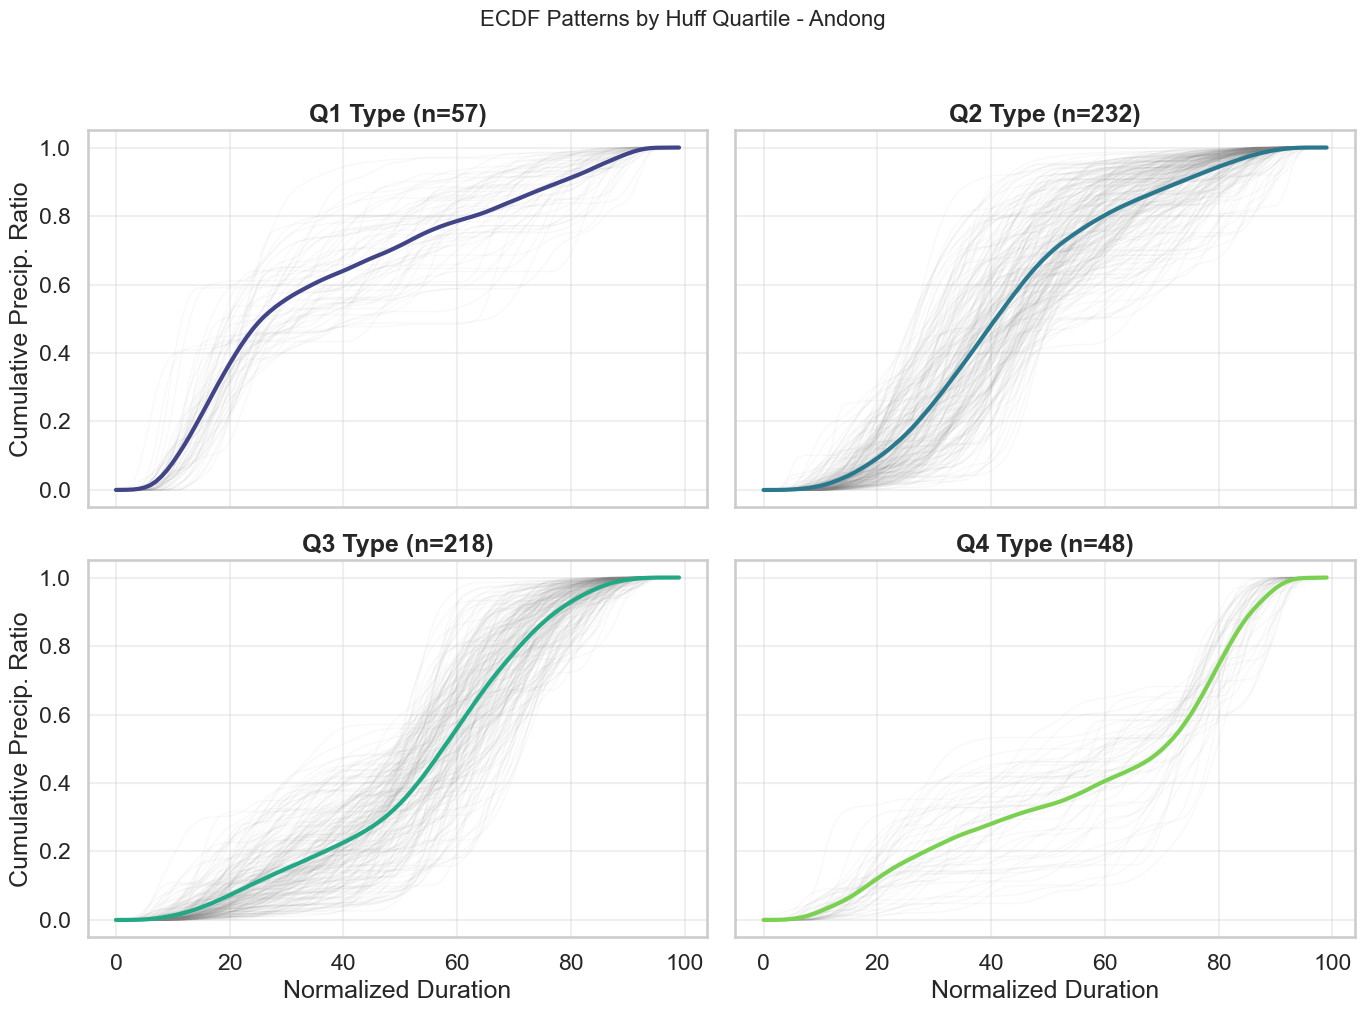

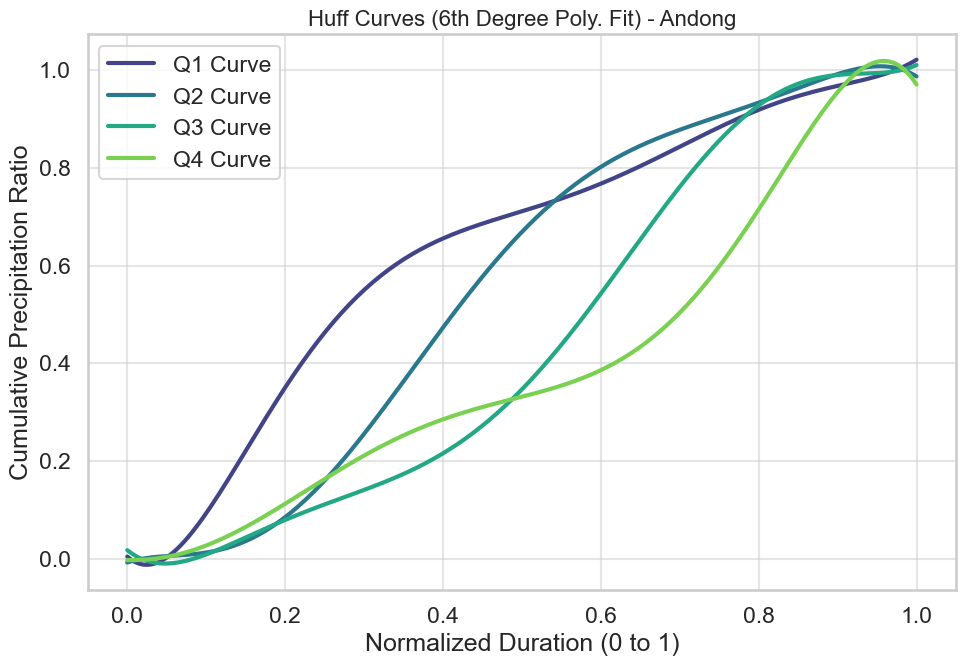

  > Fitting Beta Distribution Parameters (this may take time)...


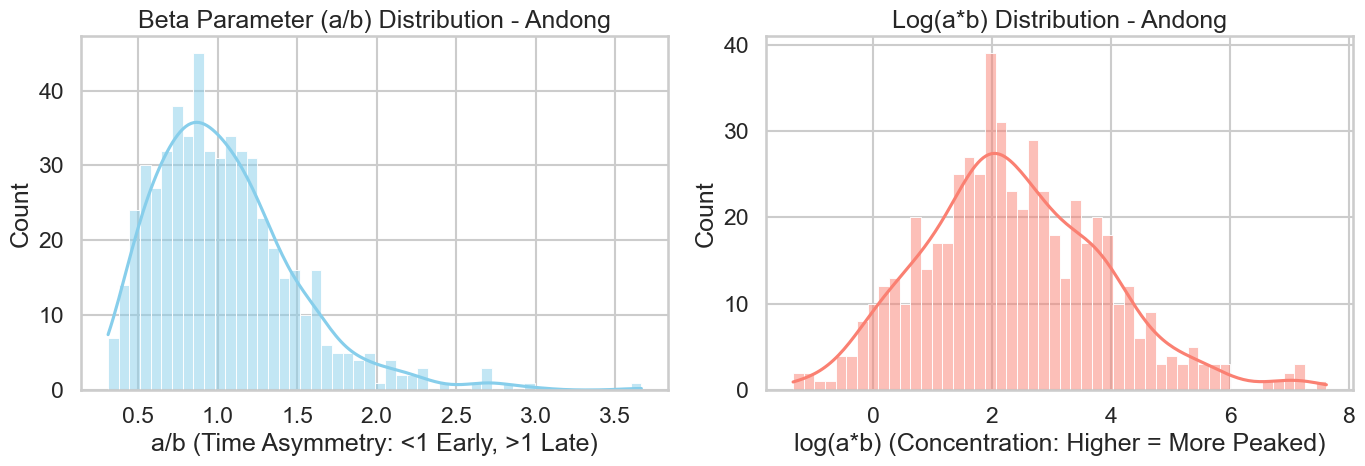

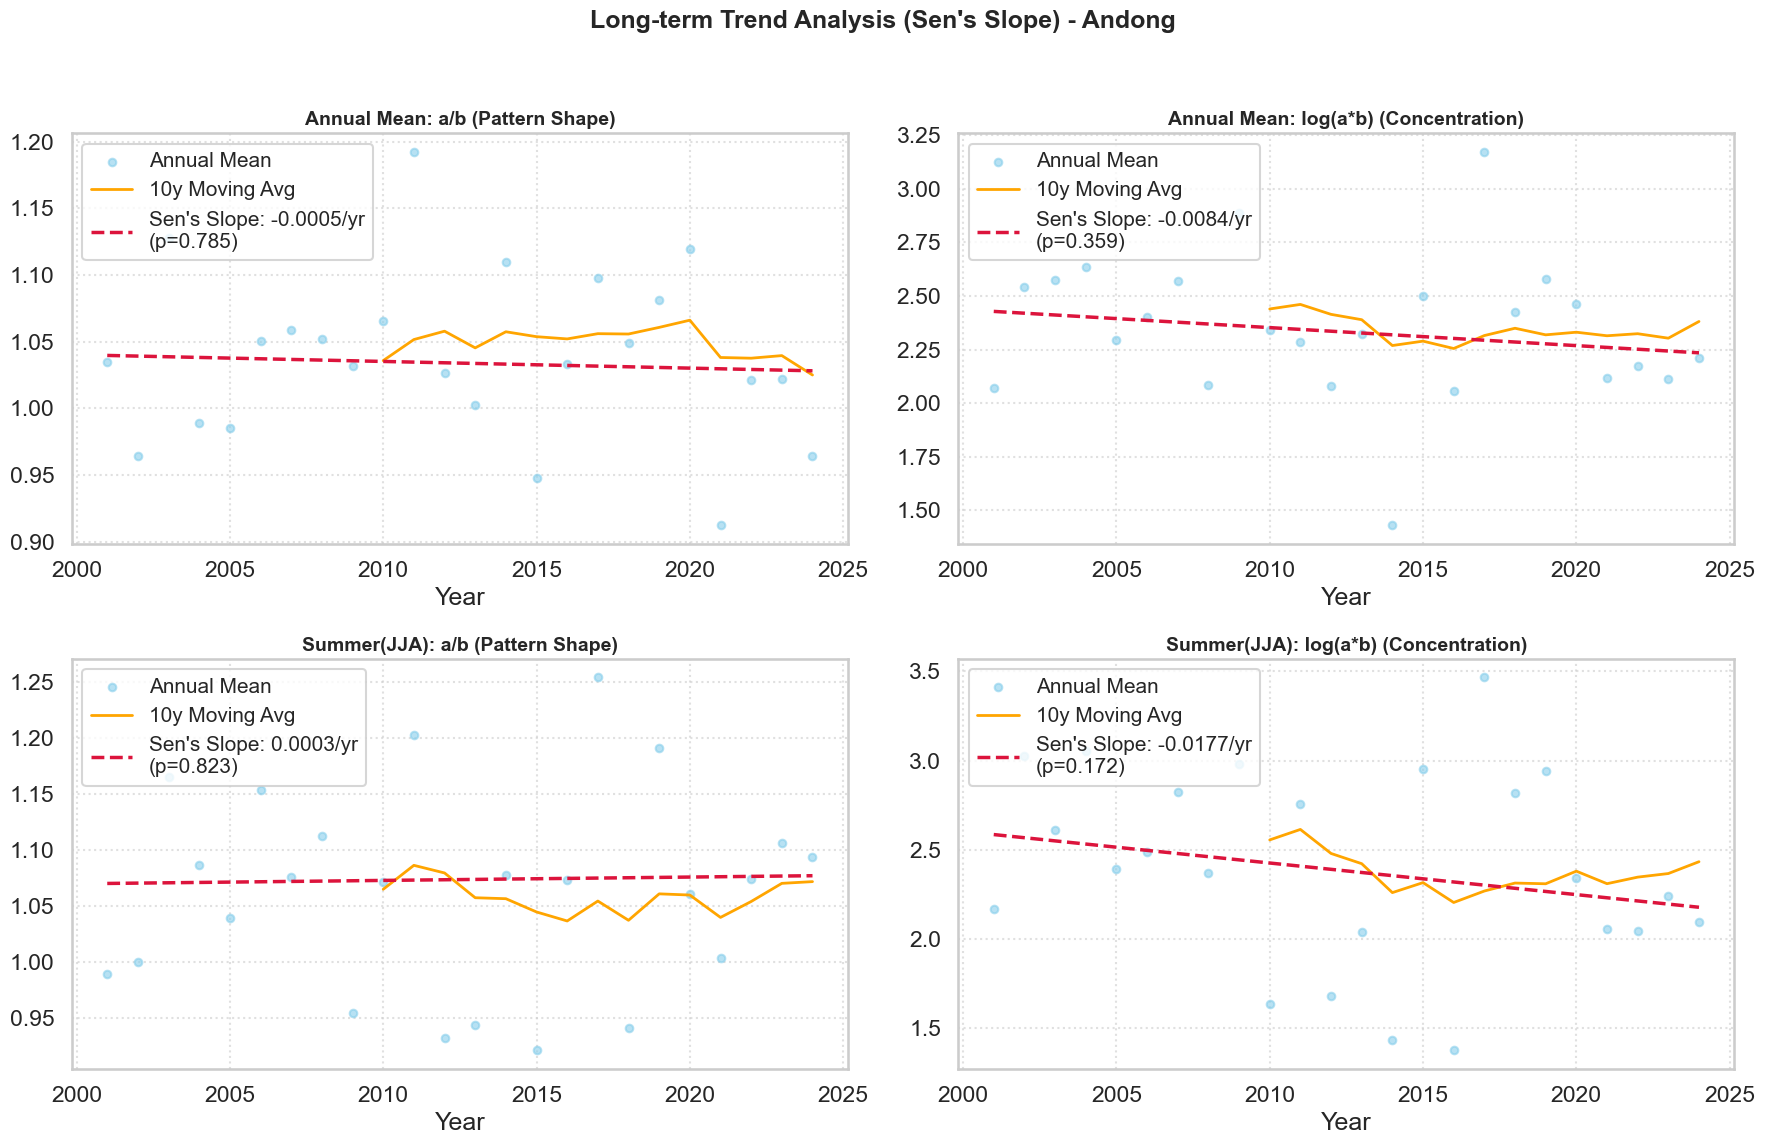


[BUSAN] Processing Started...
  > Extracting precipitation events...
    - Total Events Extracted: 645
  > Analyzing Huff Curves...


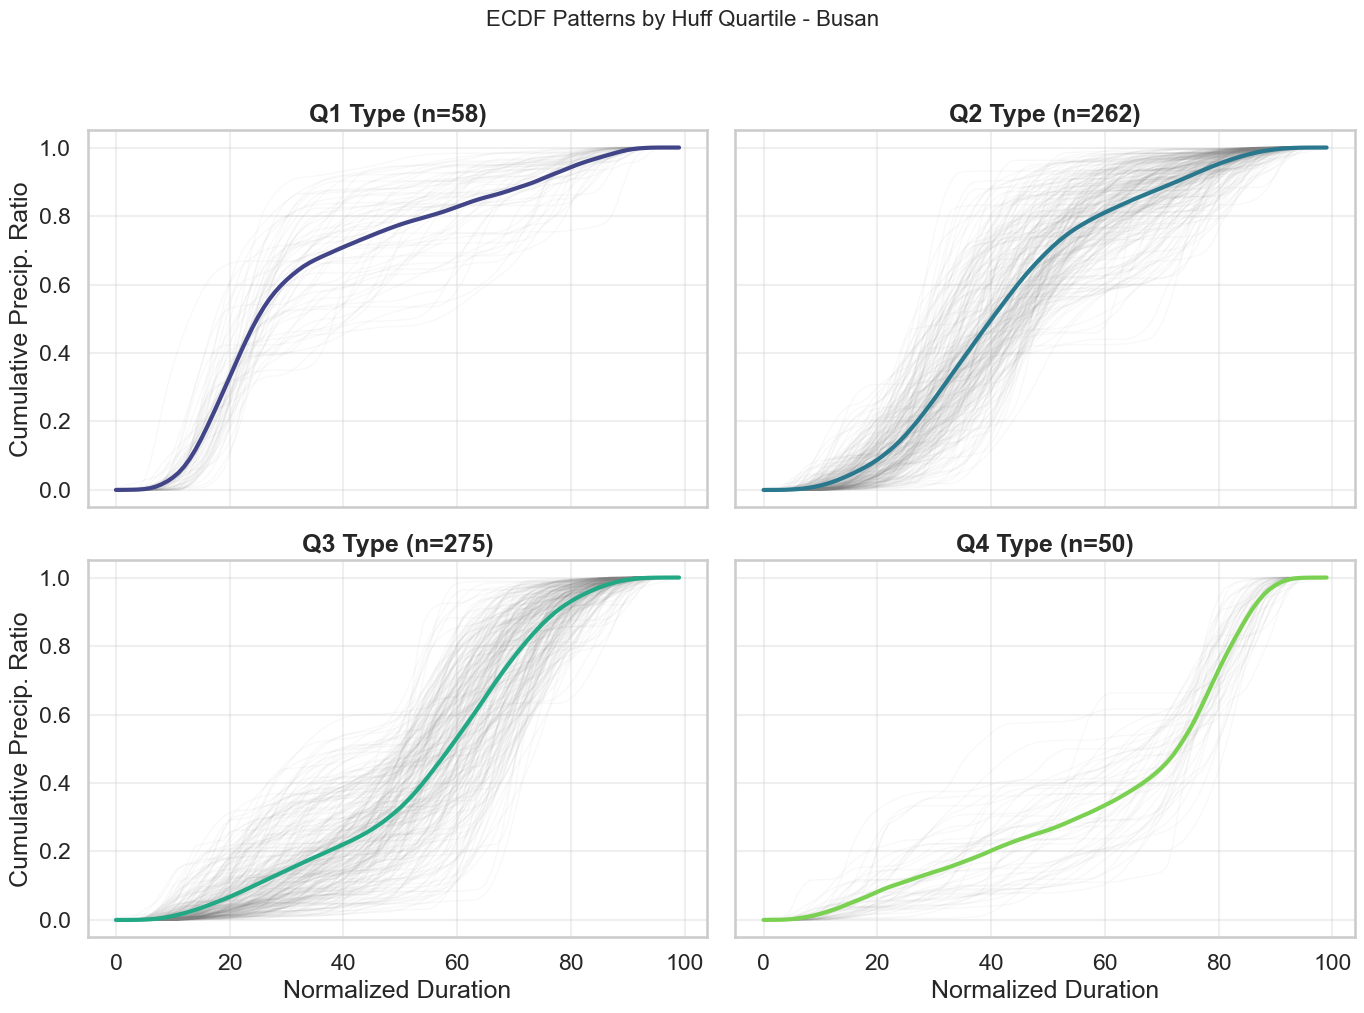

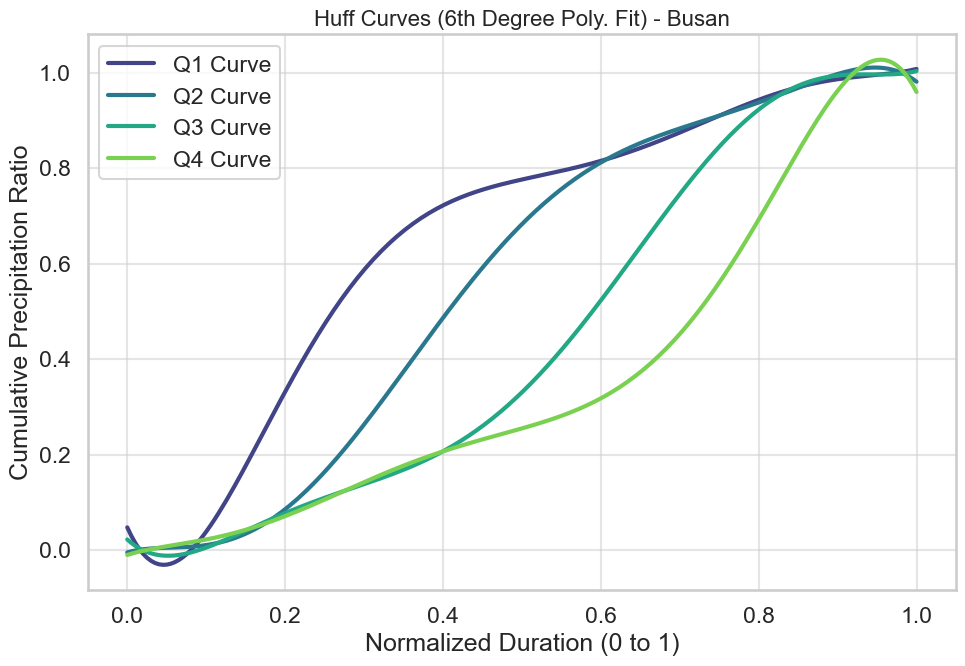

  > Fitting Beta Distribution Parameters (this may take time)...


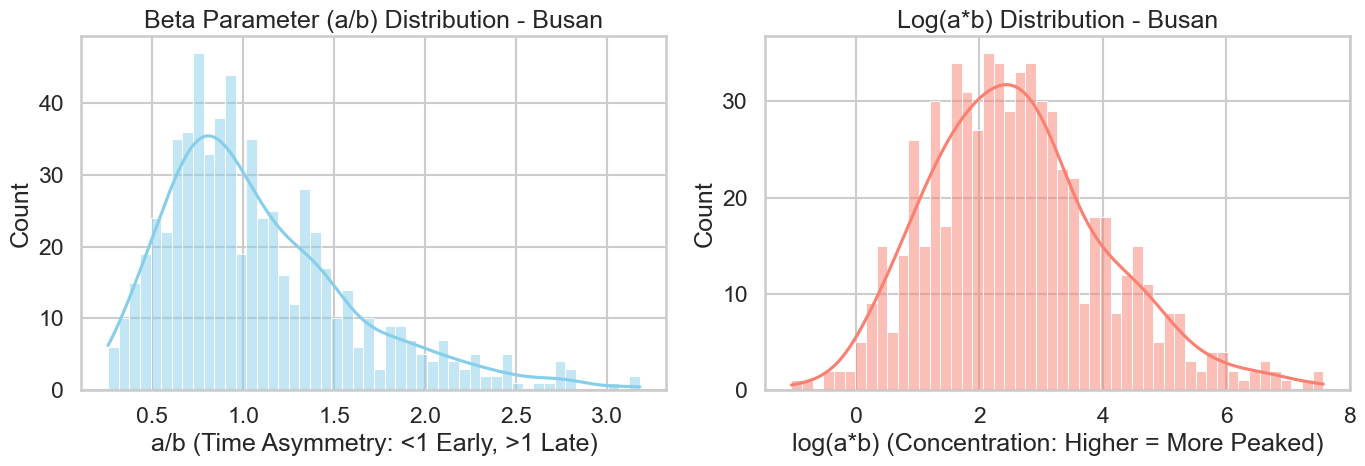

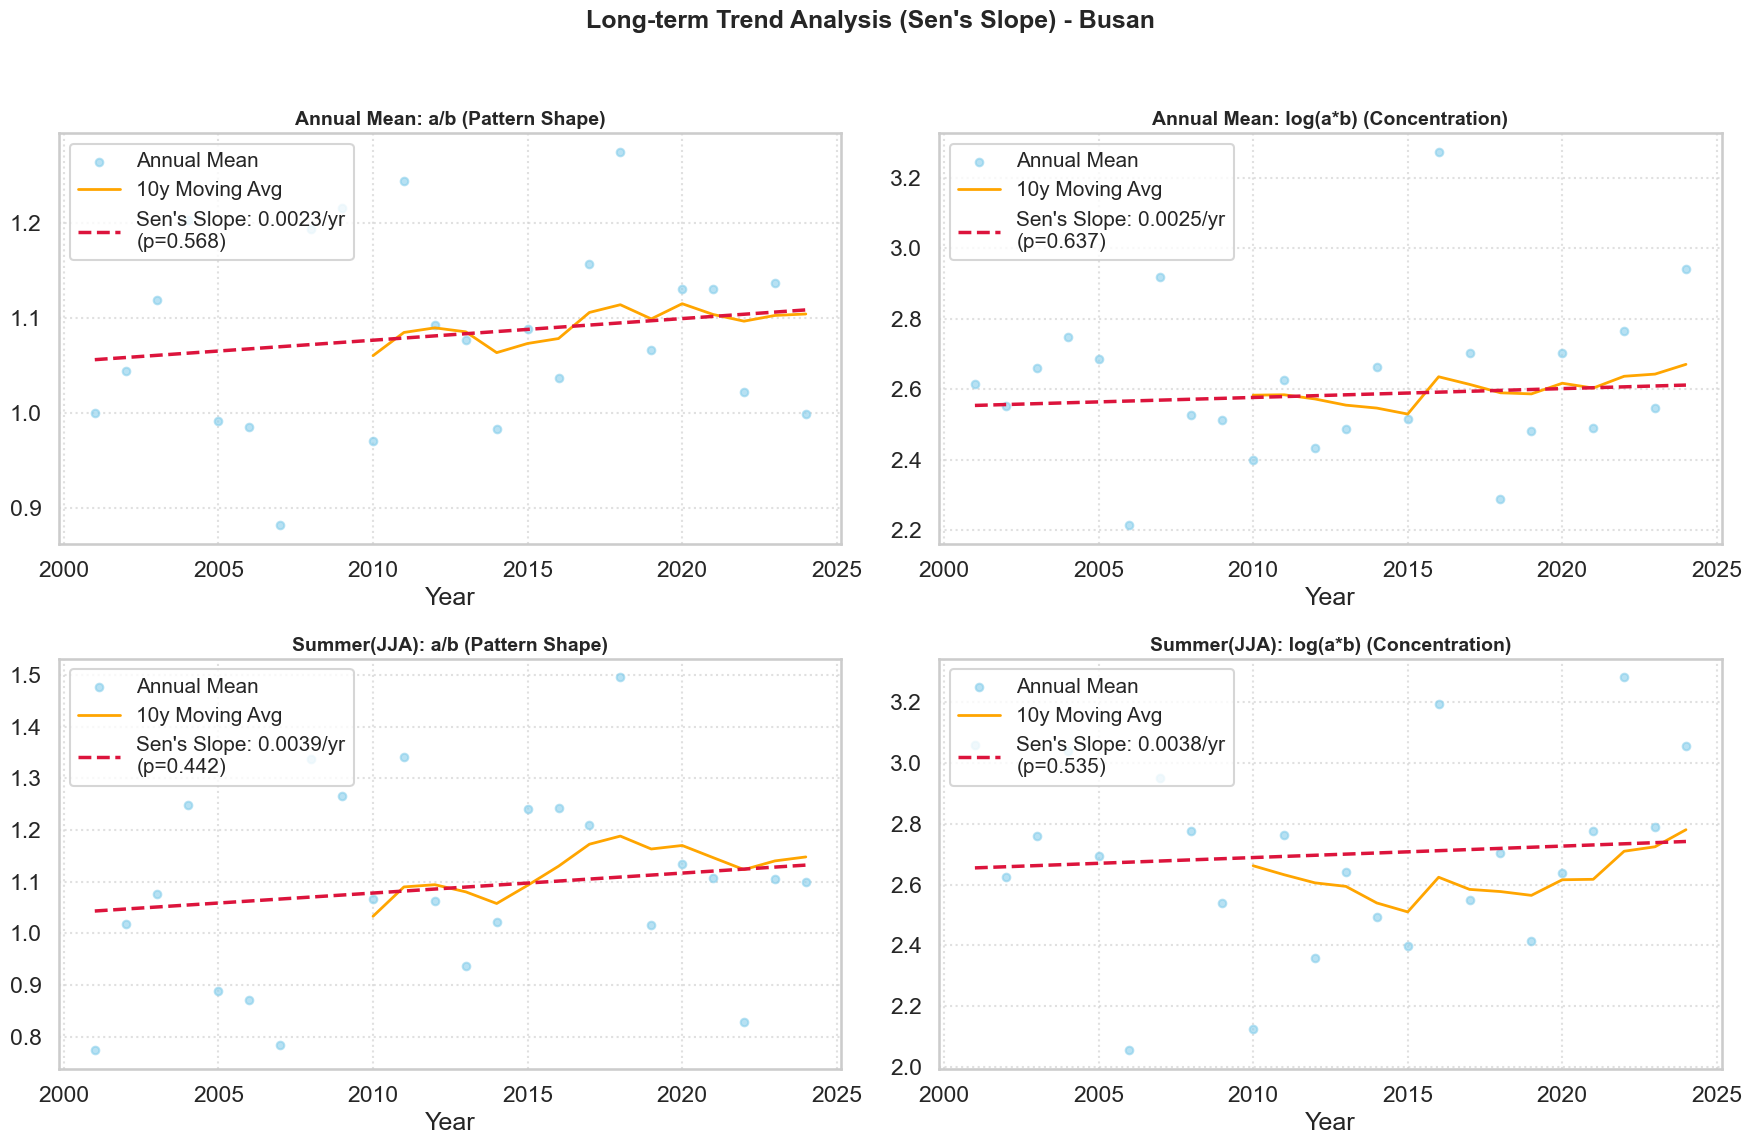


[CHUNGJU] Processing Started...
  > Extracting precipitation events...
    - Total Events Extracted: 601
  > Analyzing Huff Curves...


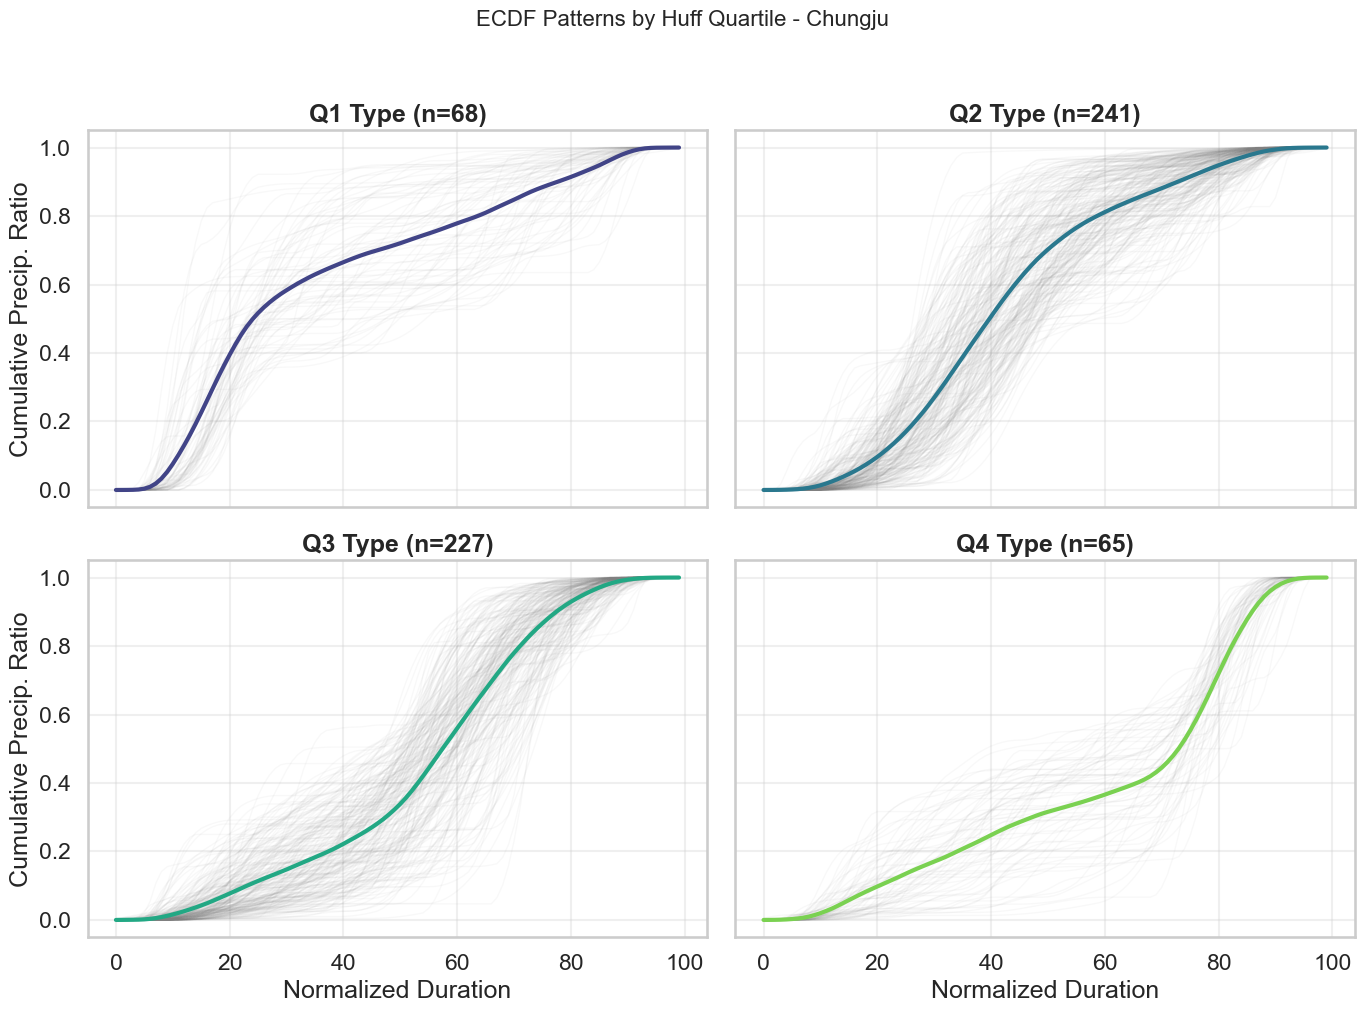

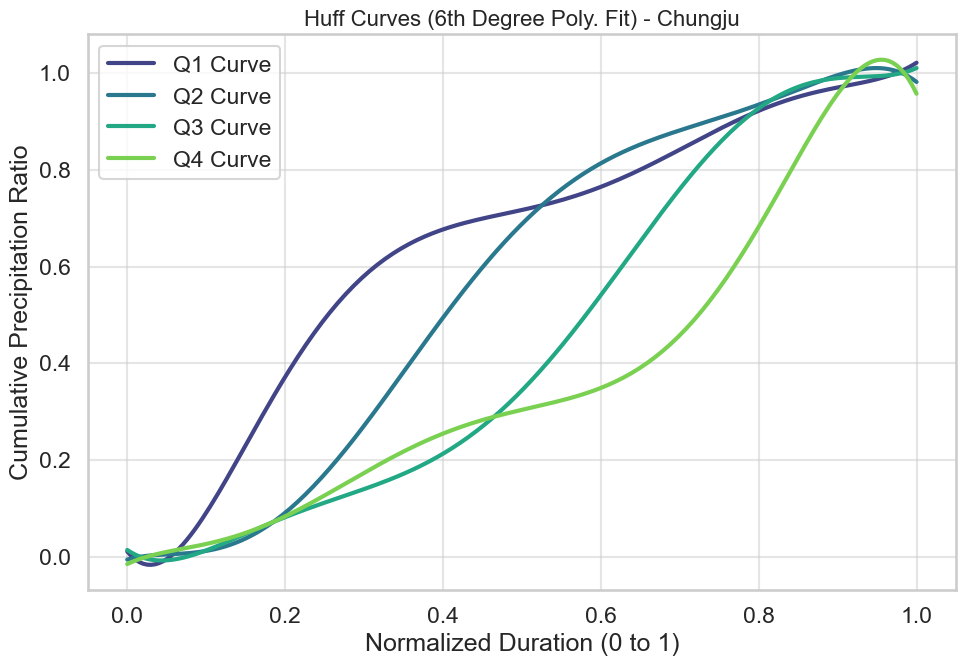

  > Fitting Beta Distribution Parameters (this may take time)...


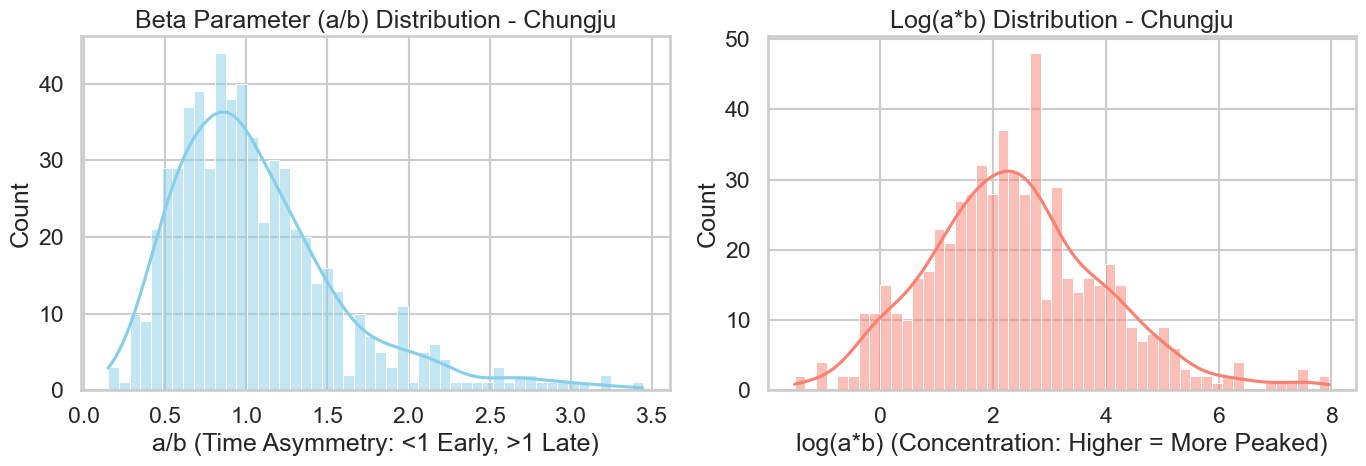

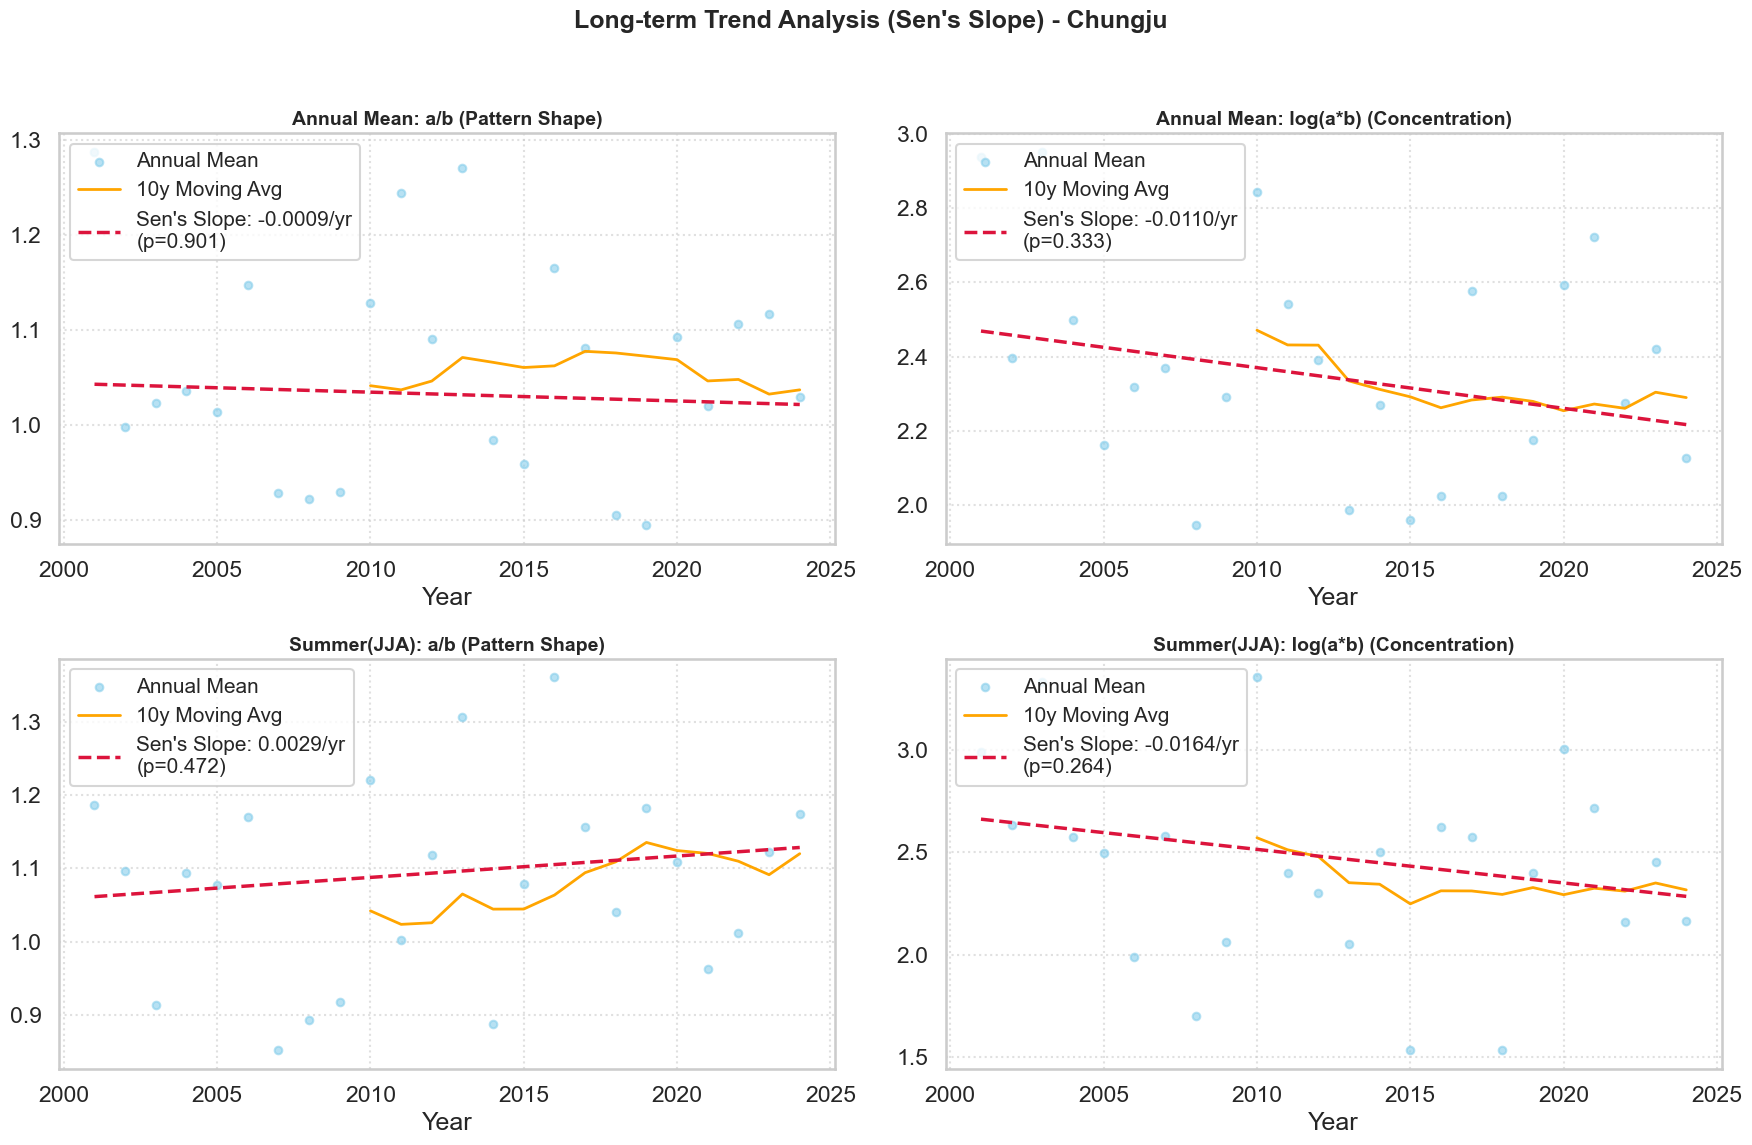


[GANGNEUNG] Processing Started...
  > Extracting precipitation events...
    - Total Events Extracted: 633
  > Analyzing Huff Curves...


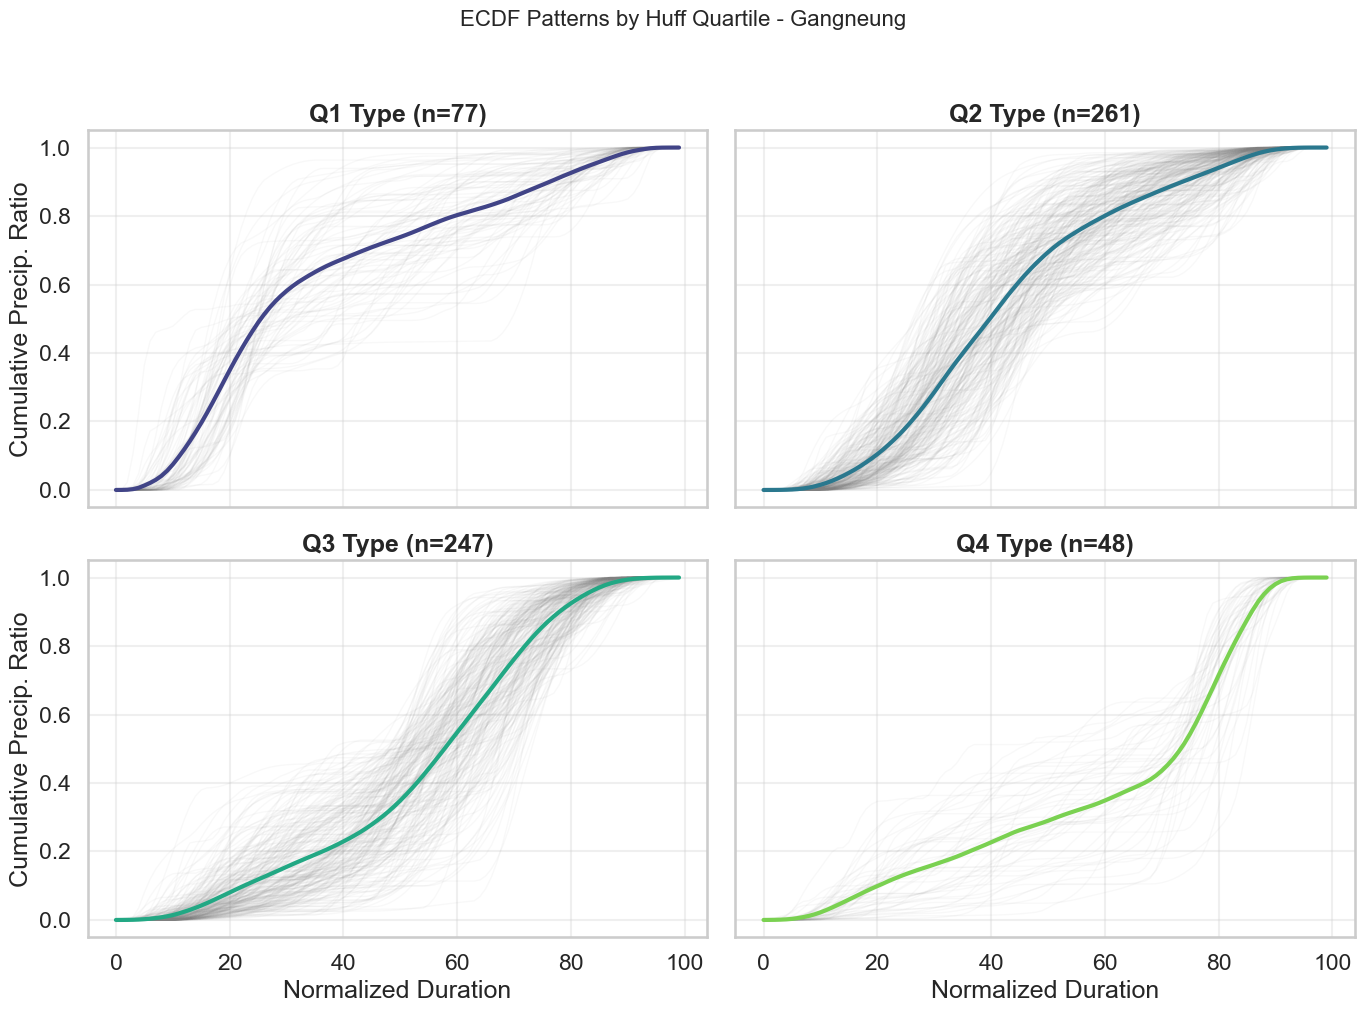

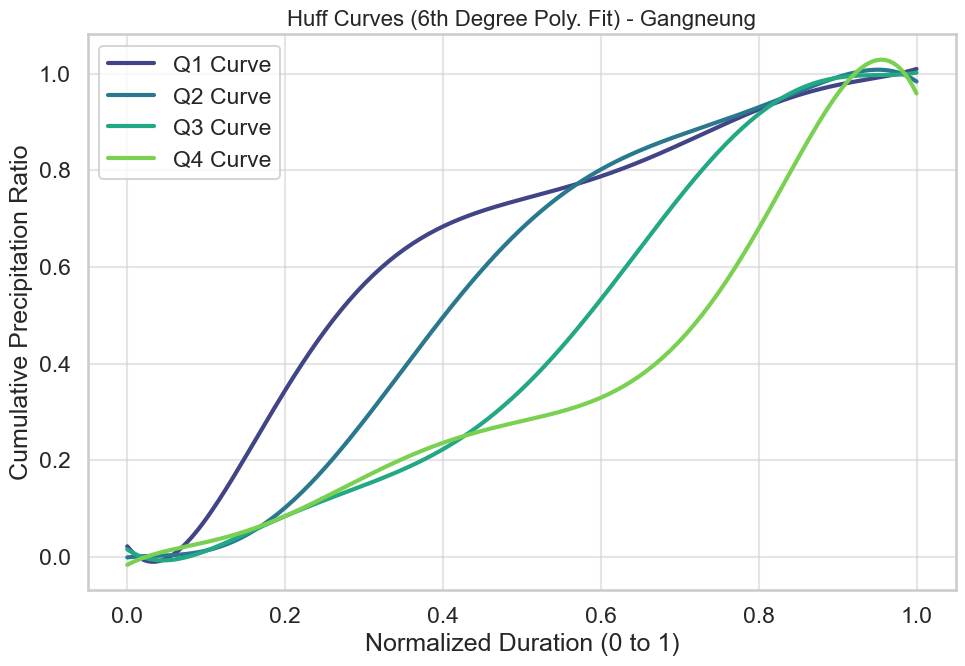

  > Fitting Beta Distribution Parameters (this may take time)...


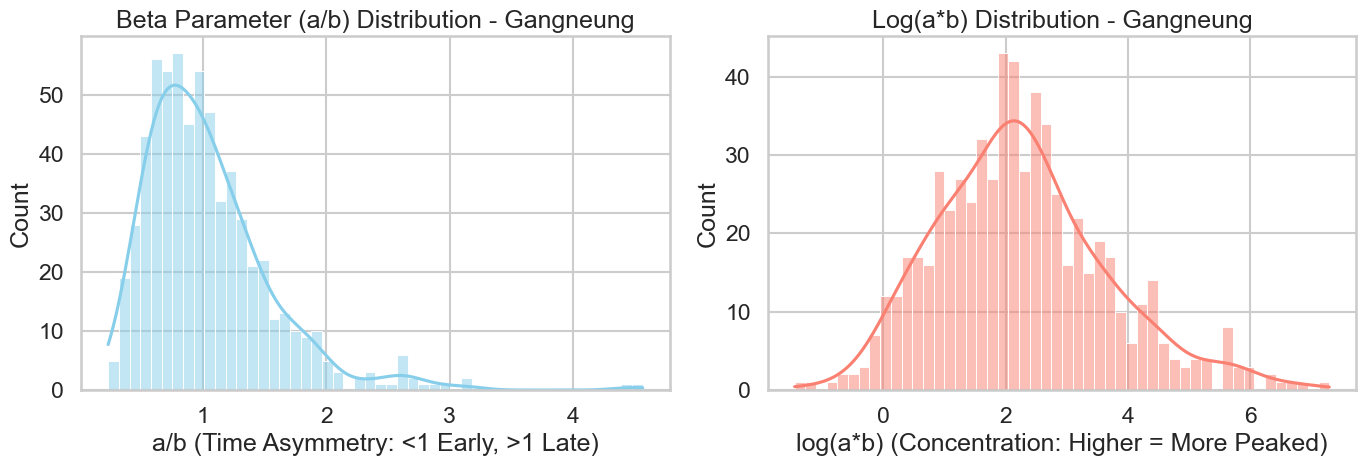

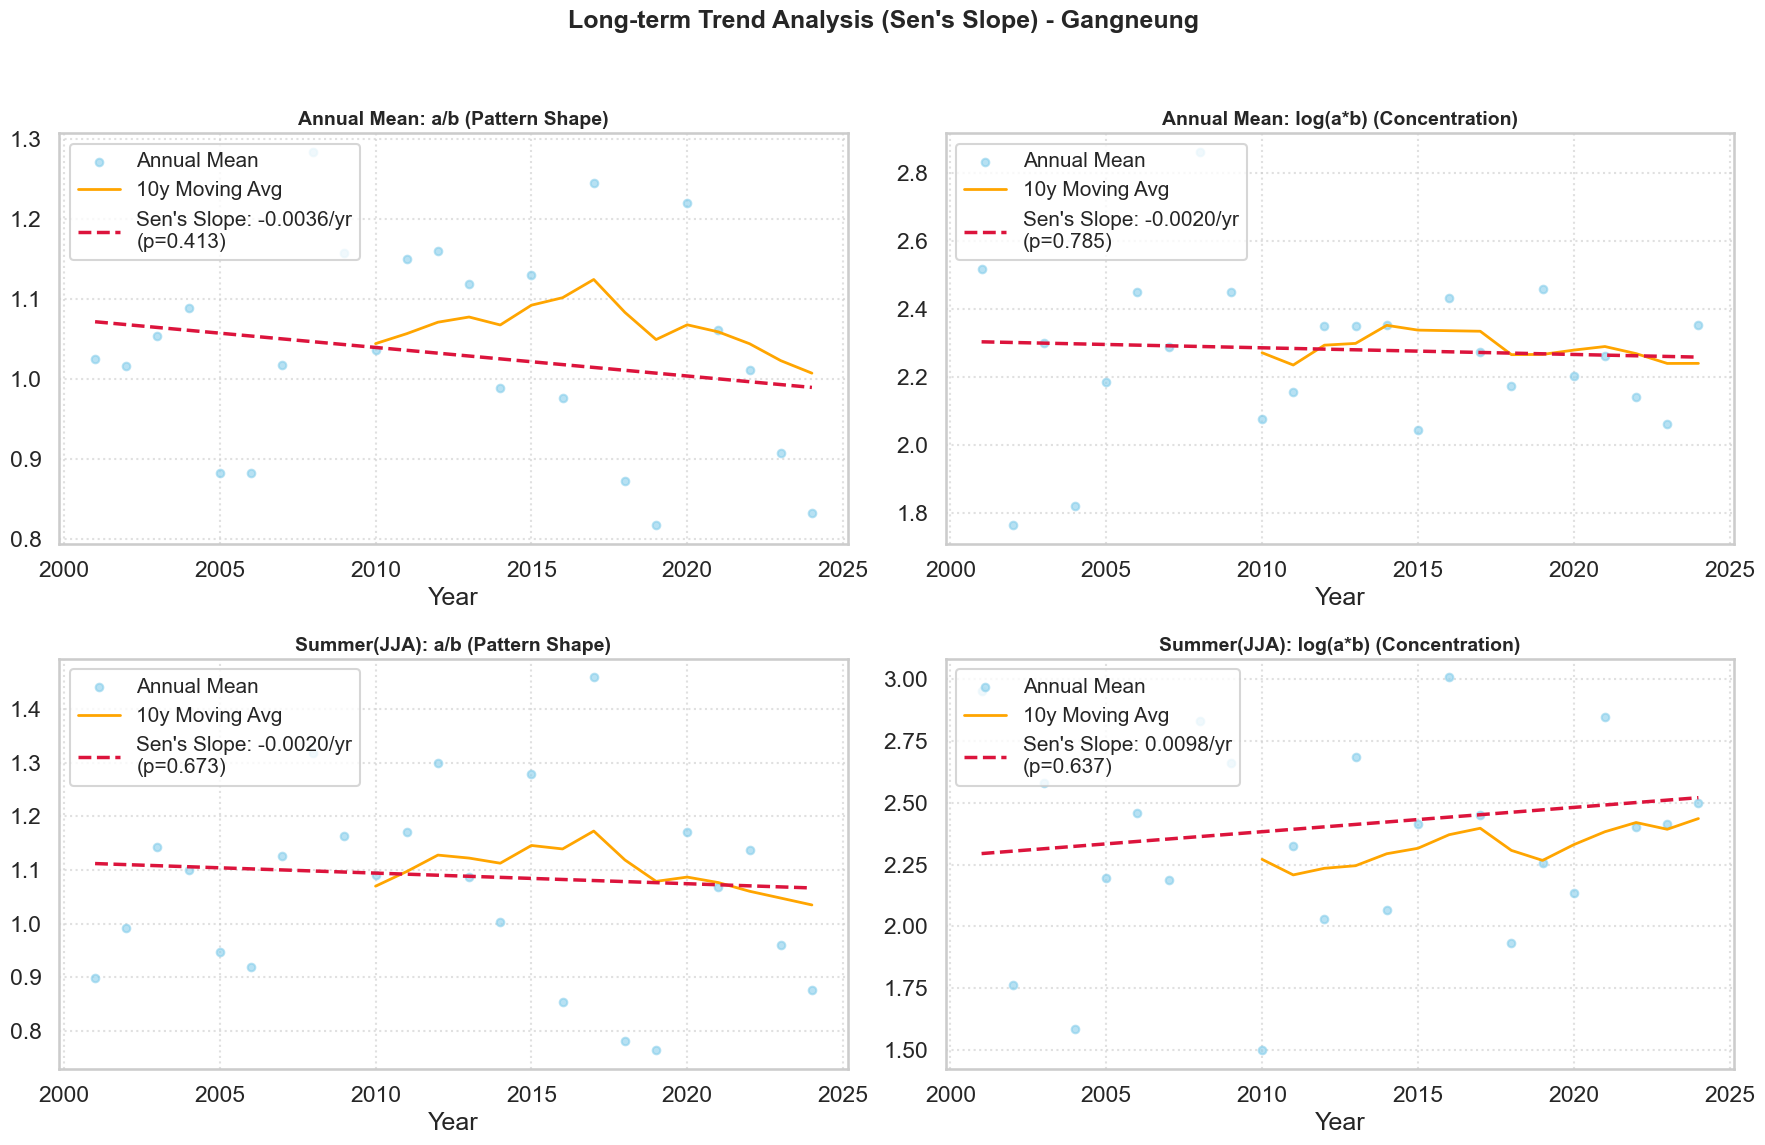


[GWANGJU] Processing Started...
  > Extracting precipitation events...
    - Total Events Extracted: 636
  > Analyzing Huff Curves...


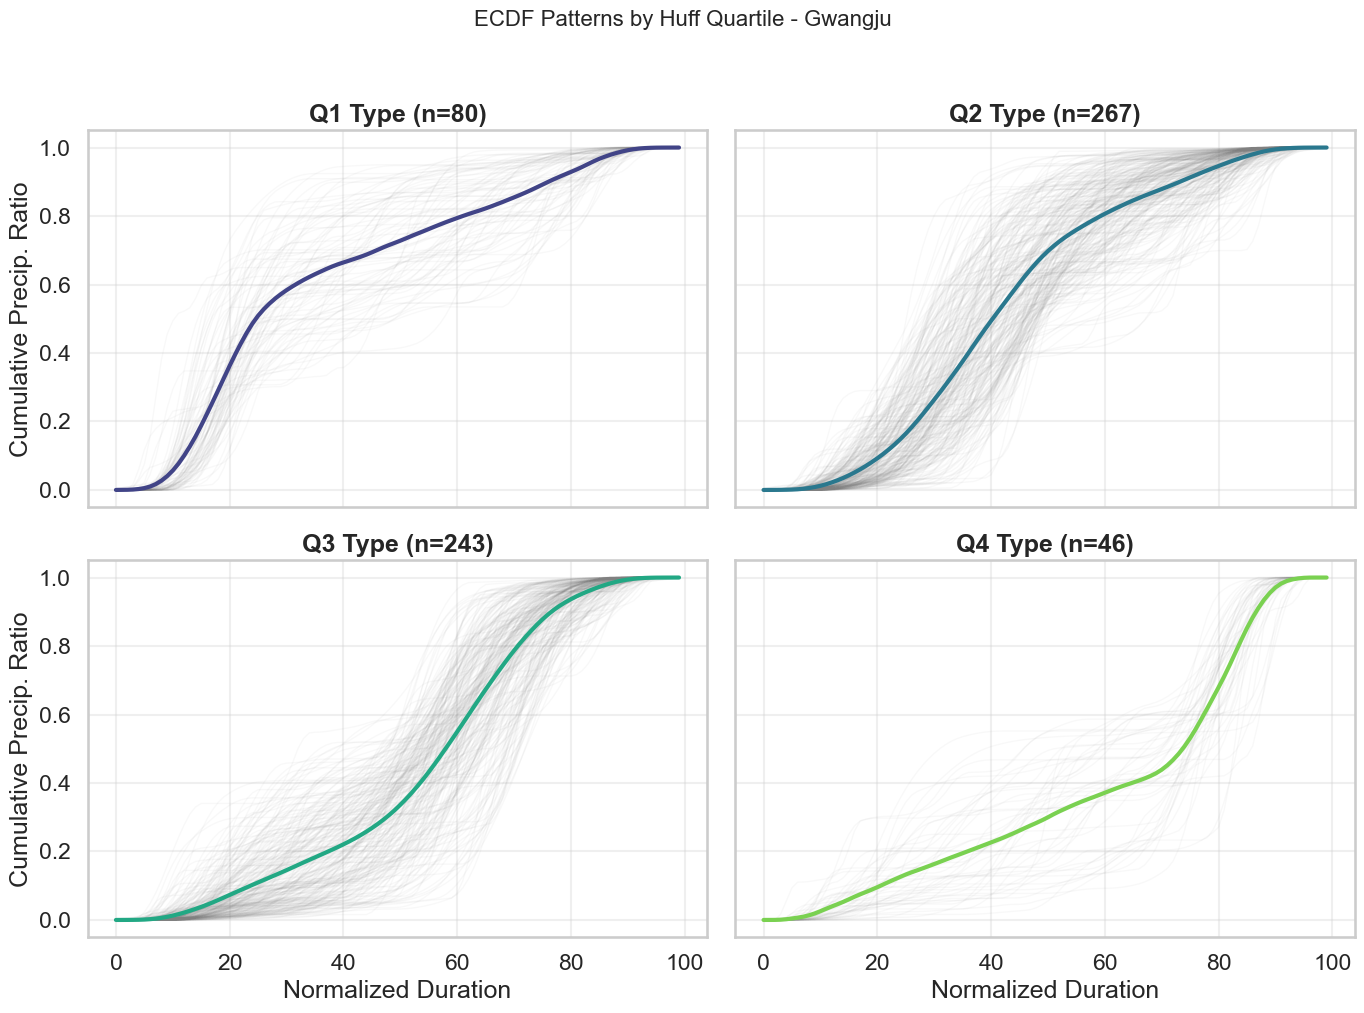

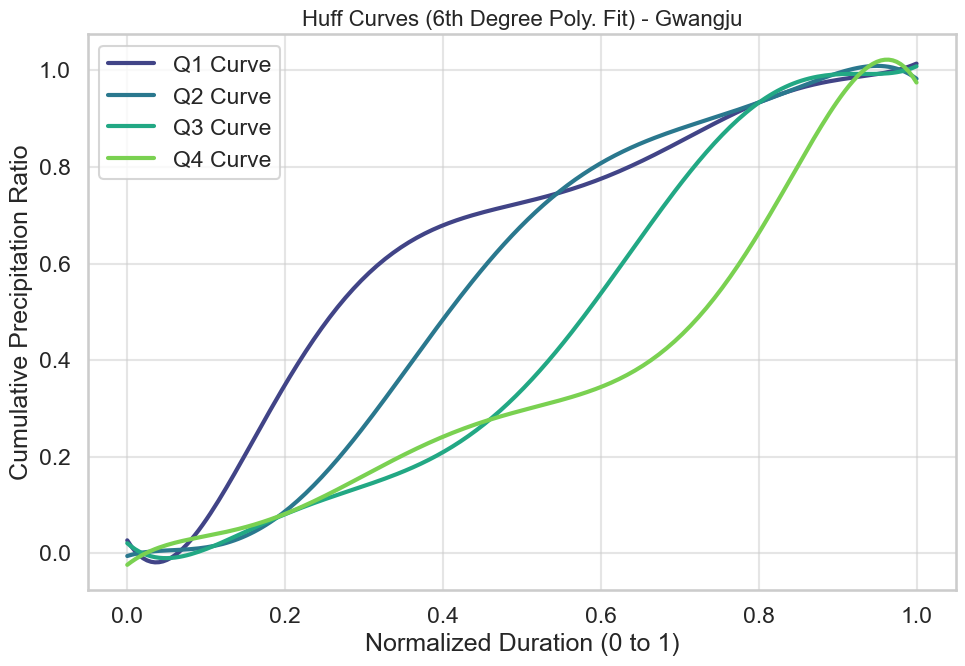

  > Fitting Beta Distribution Parameters (this may take time)...


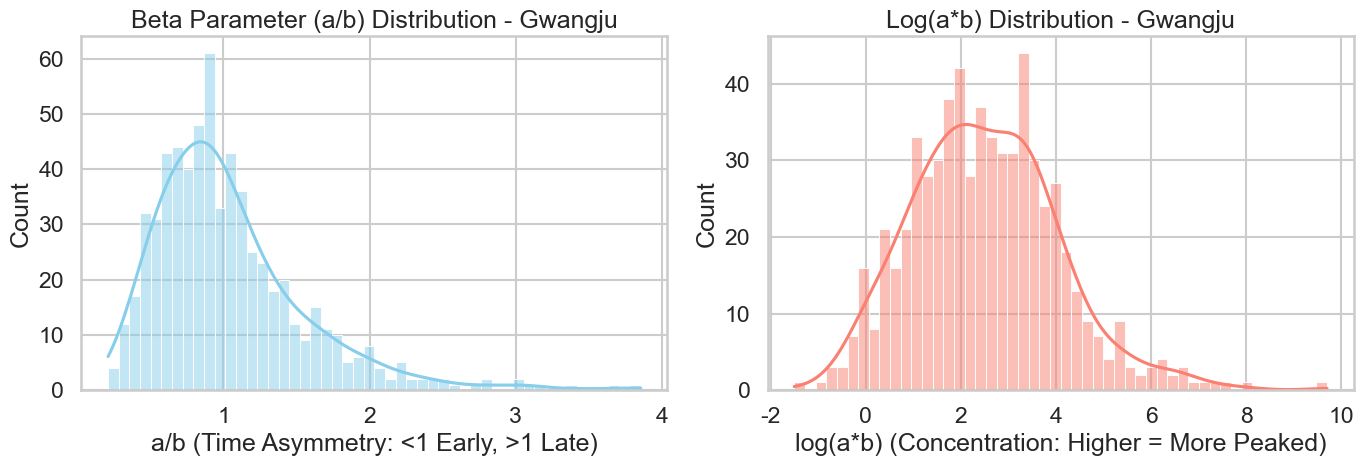

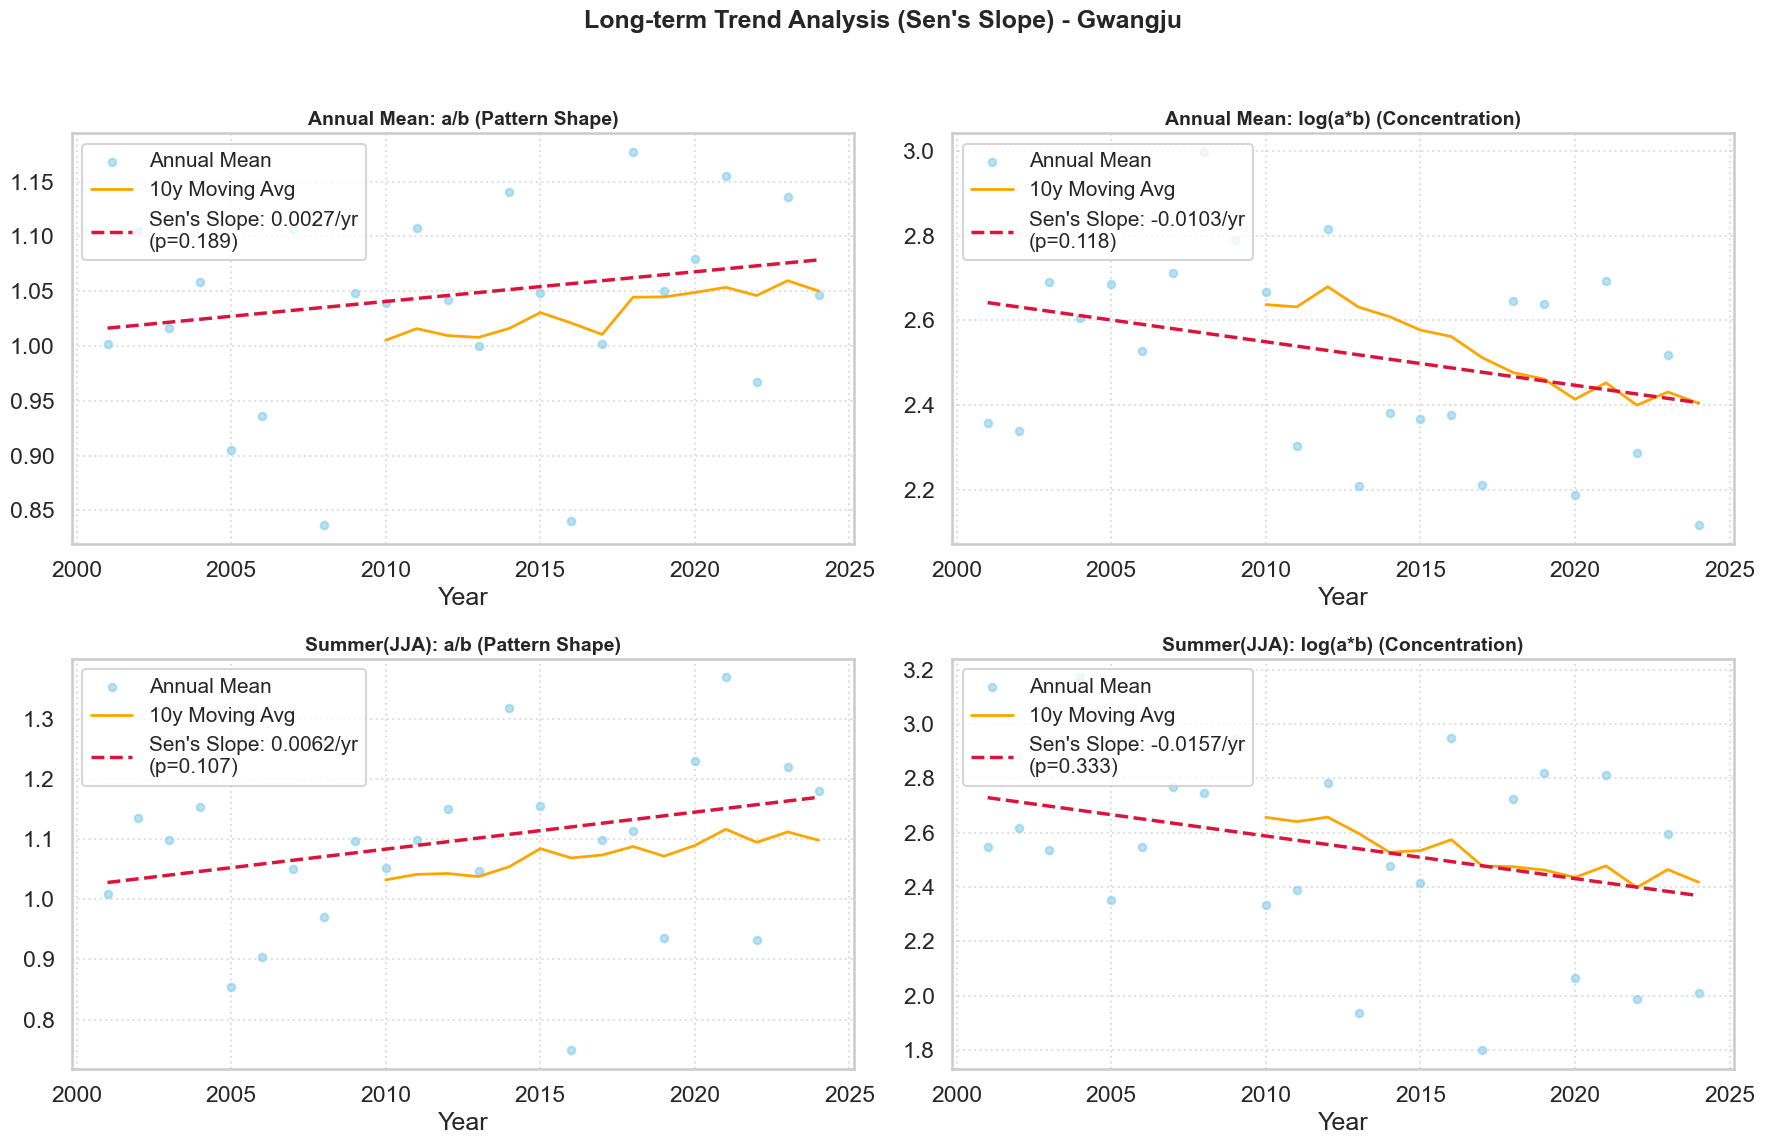


[JEJU] Processing Started...
  > Extracting precipitation events...
    - Total Events Extracted: 619
  > Analyzing Huff Curves...


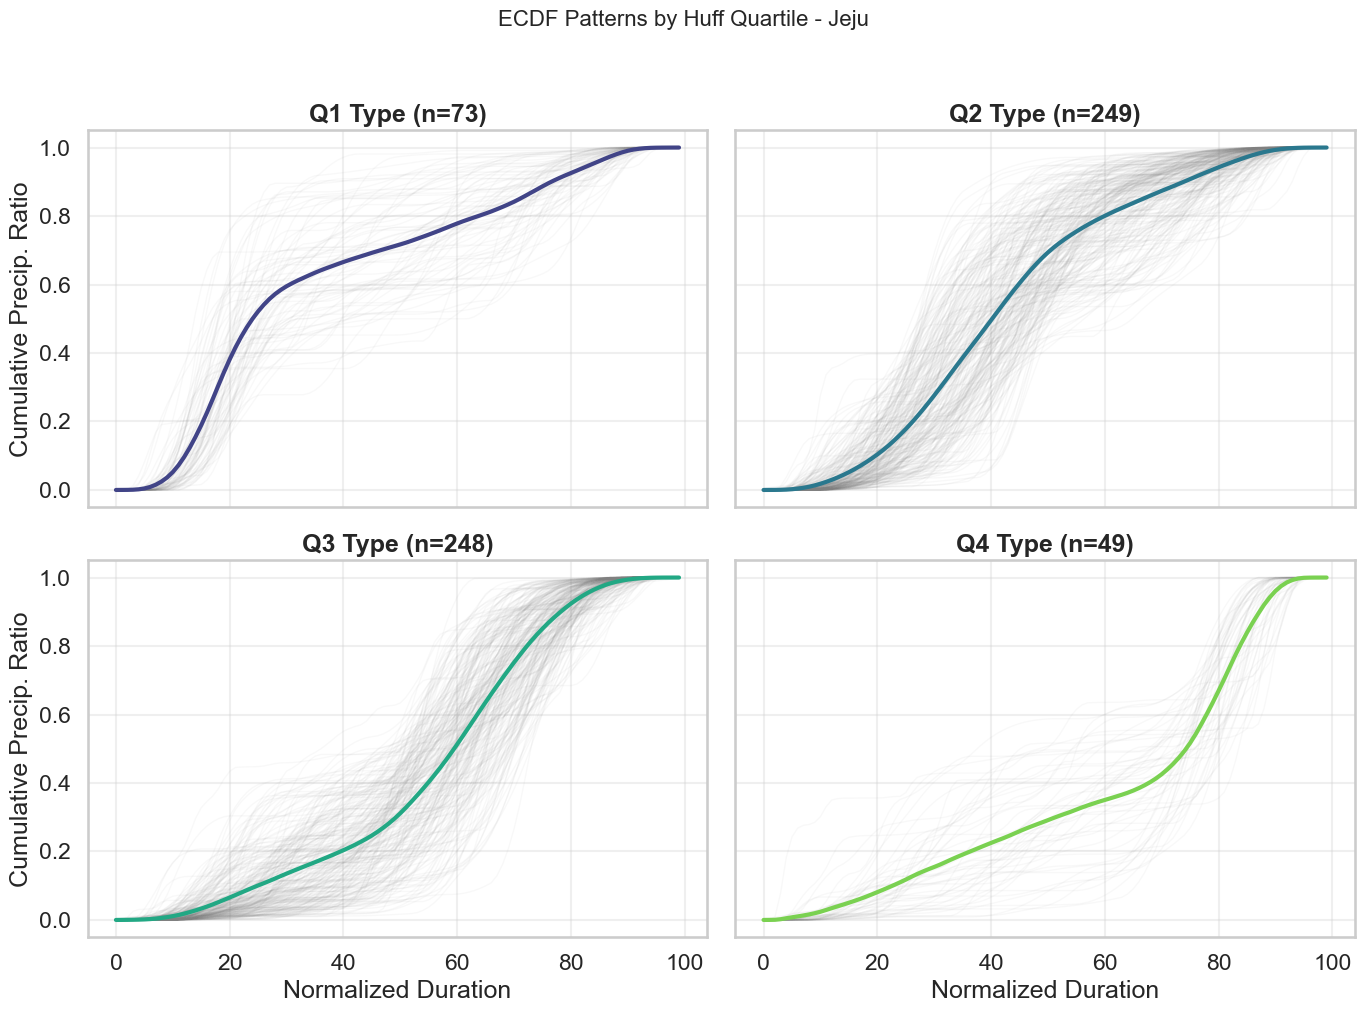

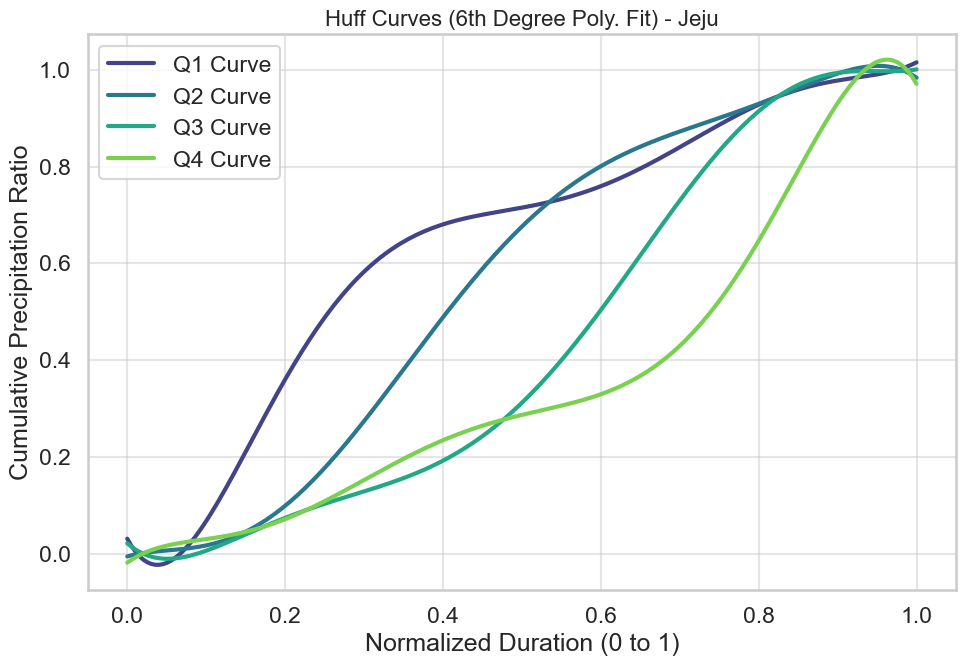

  > Fitting Beta Distribution Parameters (this may take time)...


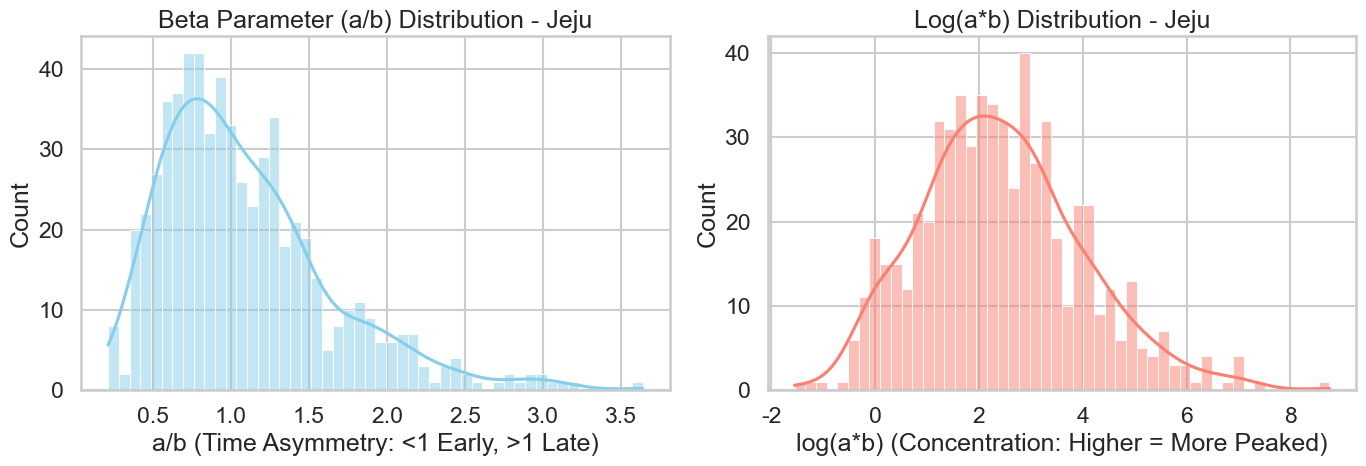

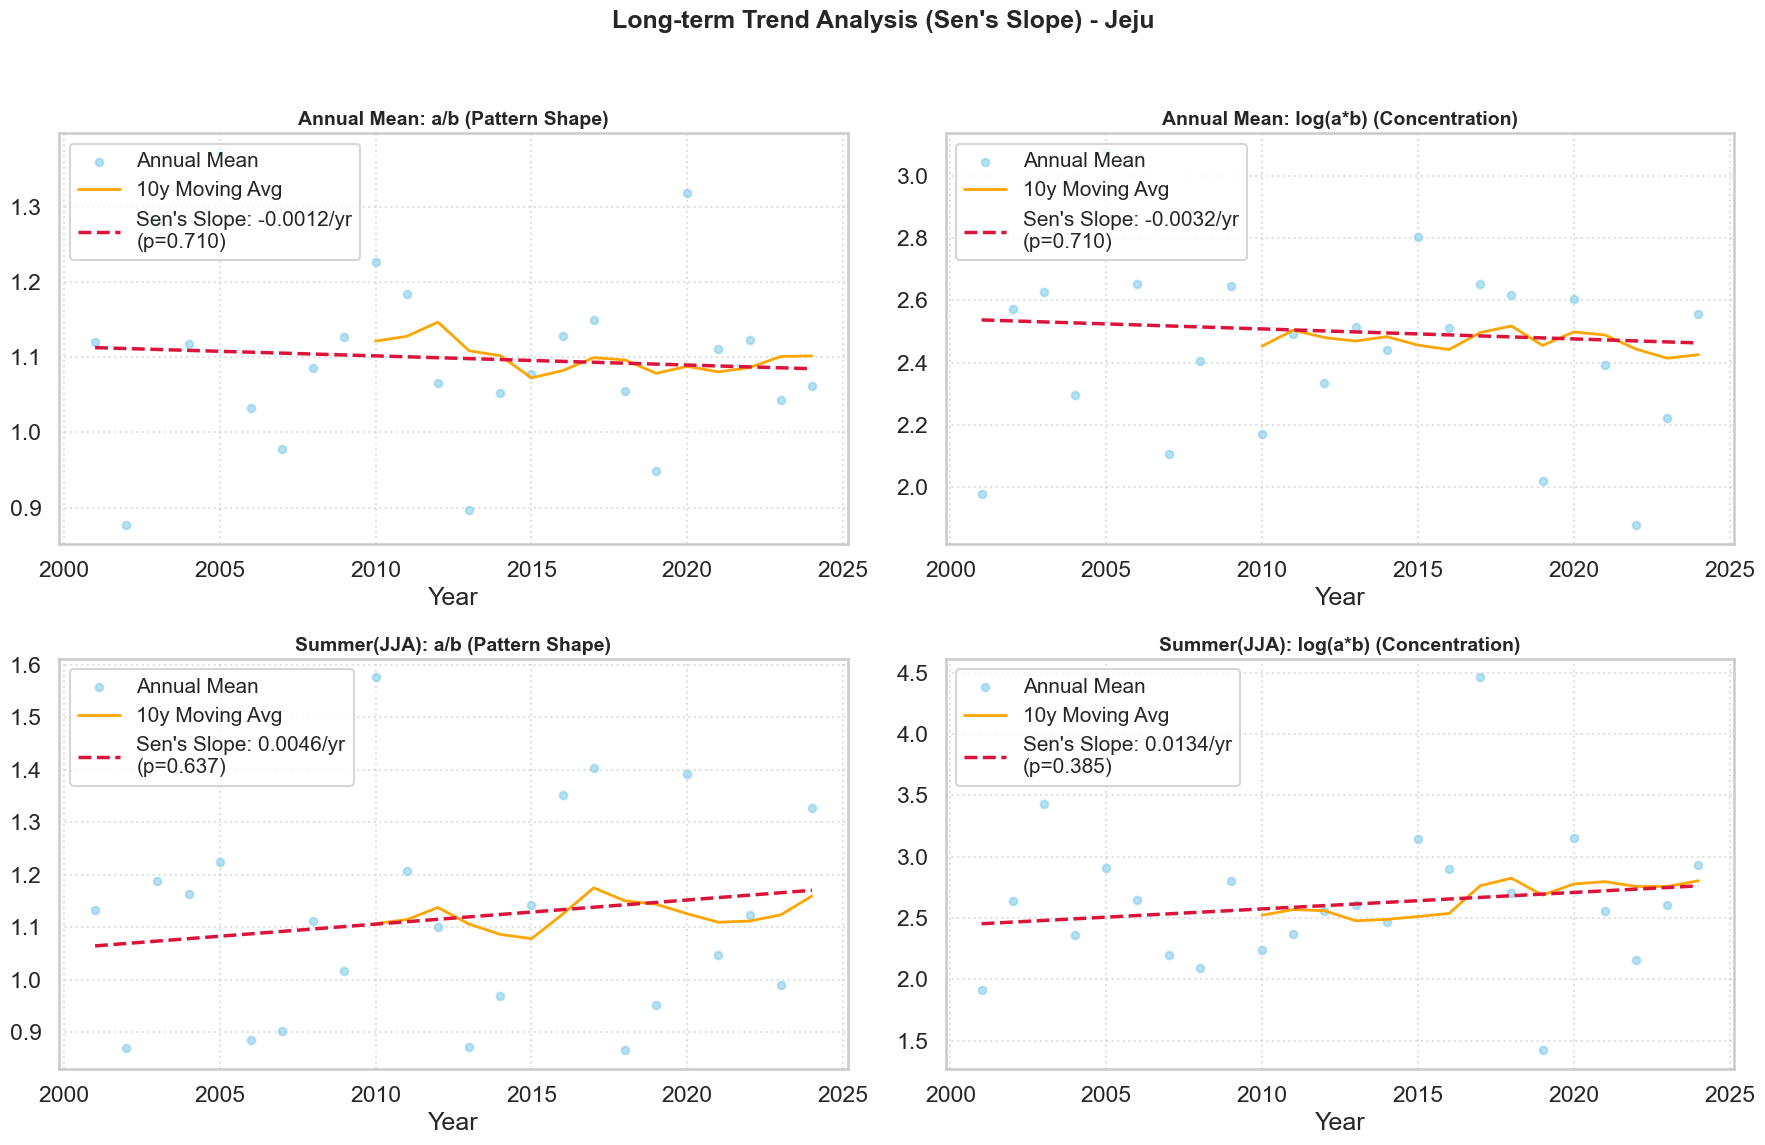


[SEOUL] Processing Started...
  > Extracting precipitation events...
    - Total Events Extracted: 594
  > Analyzing Huff Curves...


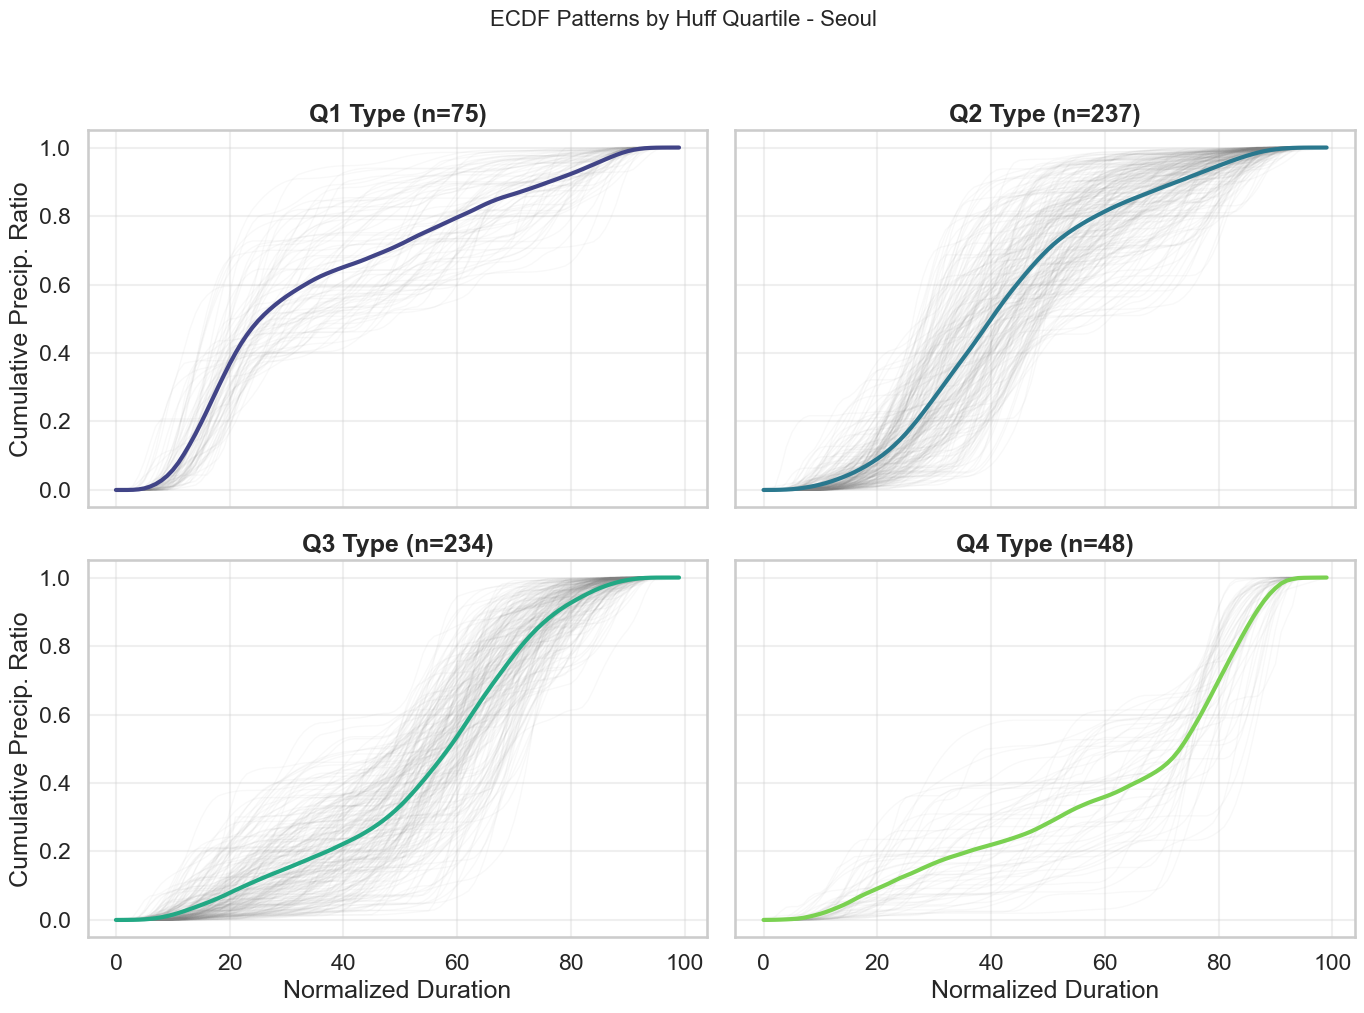

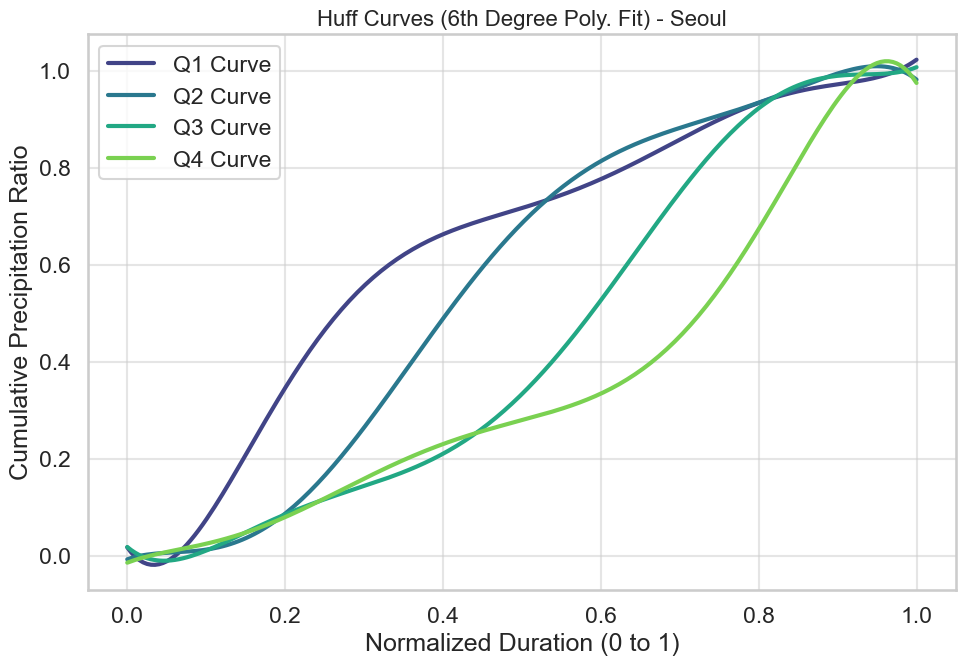

  > Fitting Beta Distribution Parameters (this may take time)...


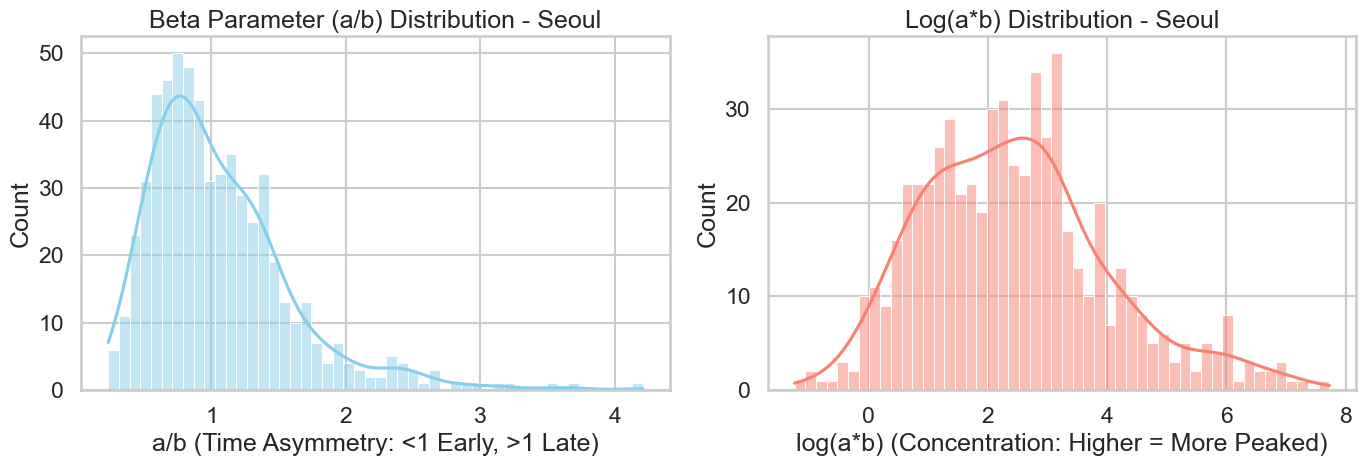

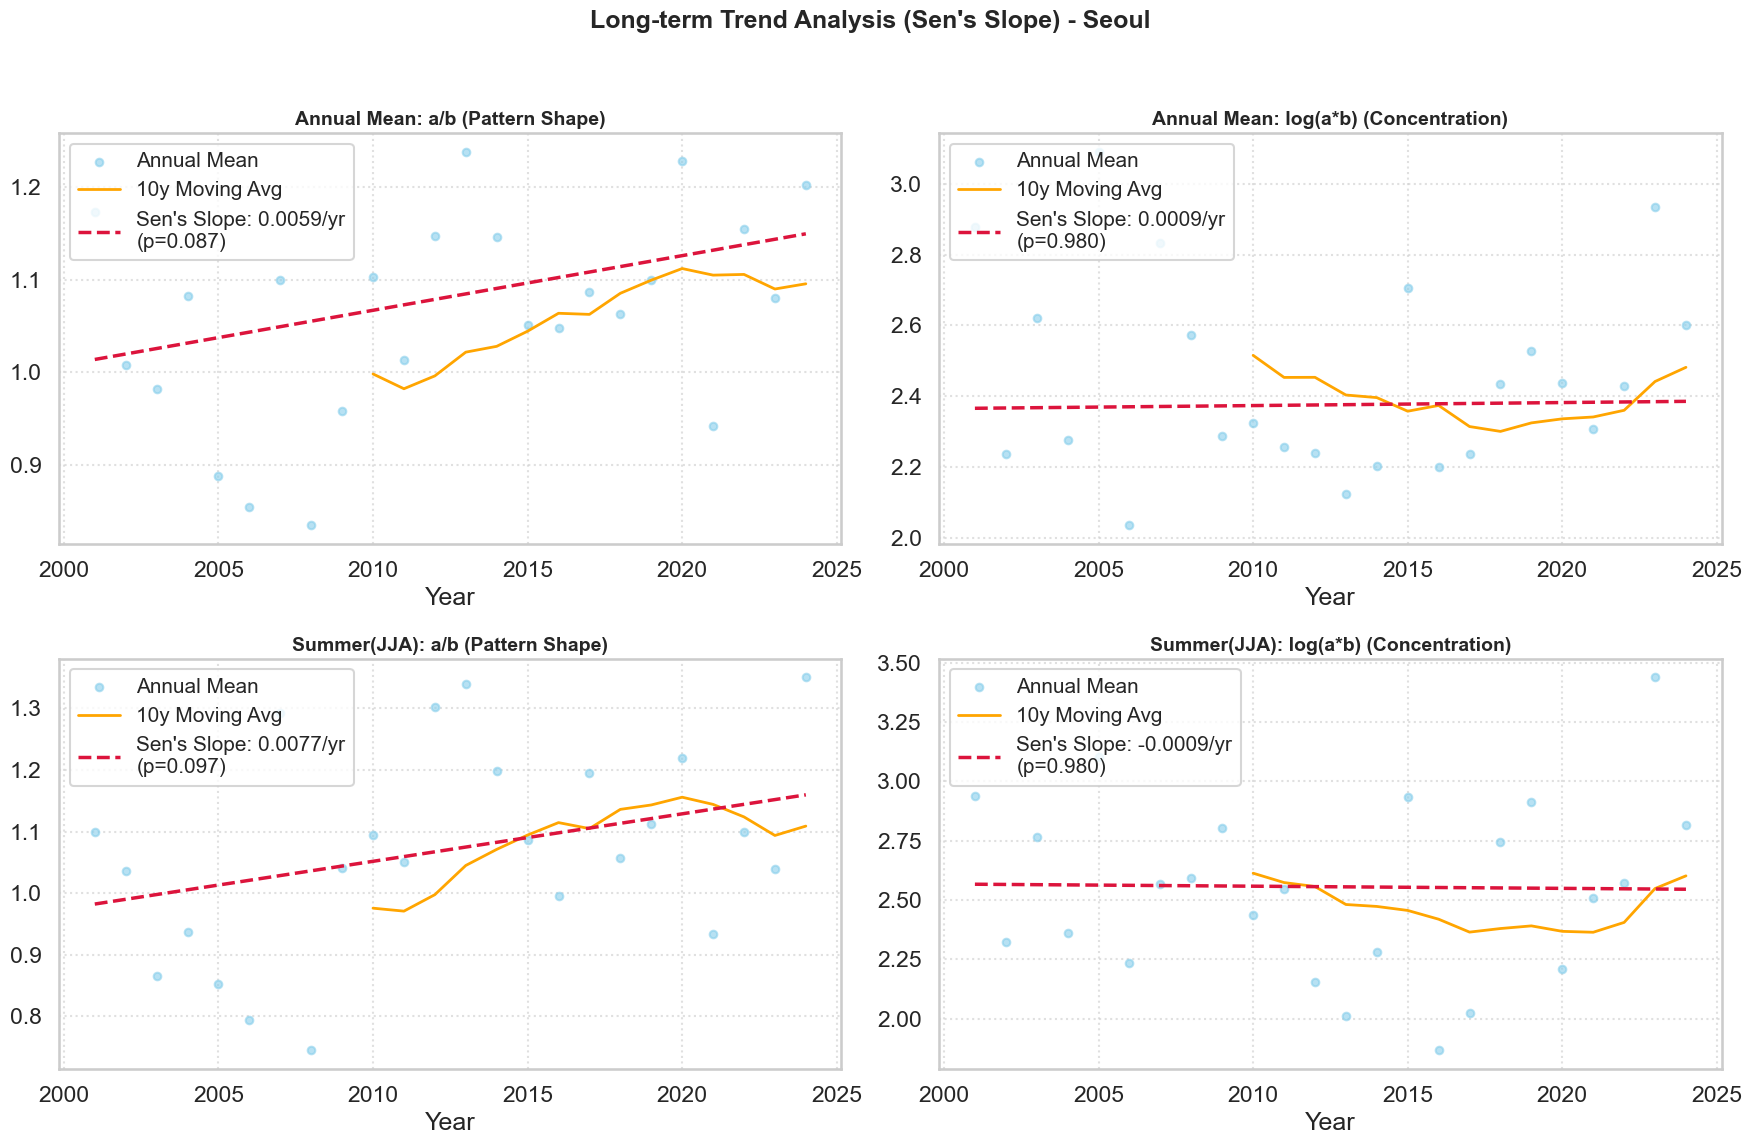


[YEOSU] Processing Started...
  > Extracting precipitation events...
    - Total Events Extracted: 626
  > Analyzing Huff Curves...


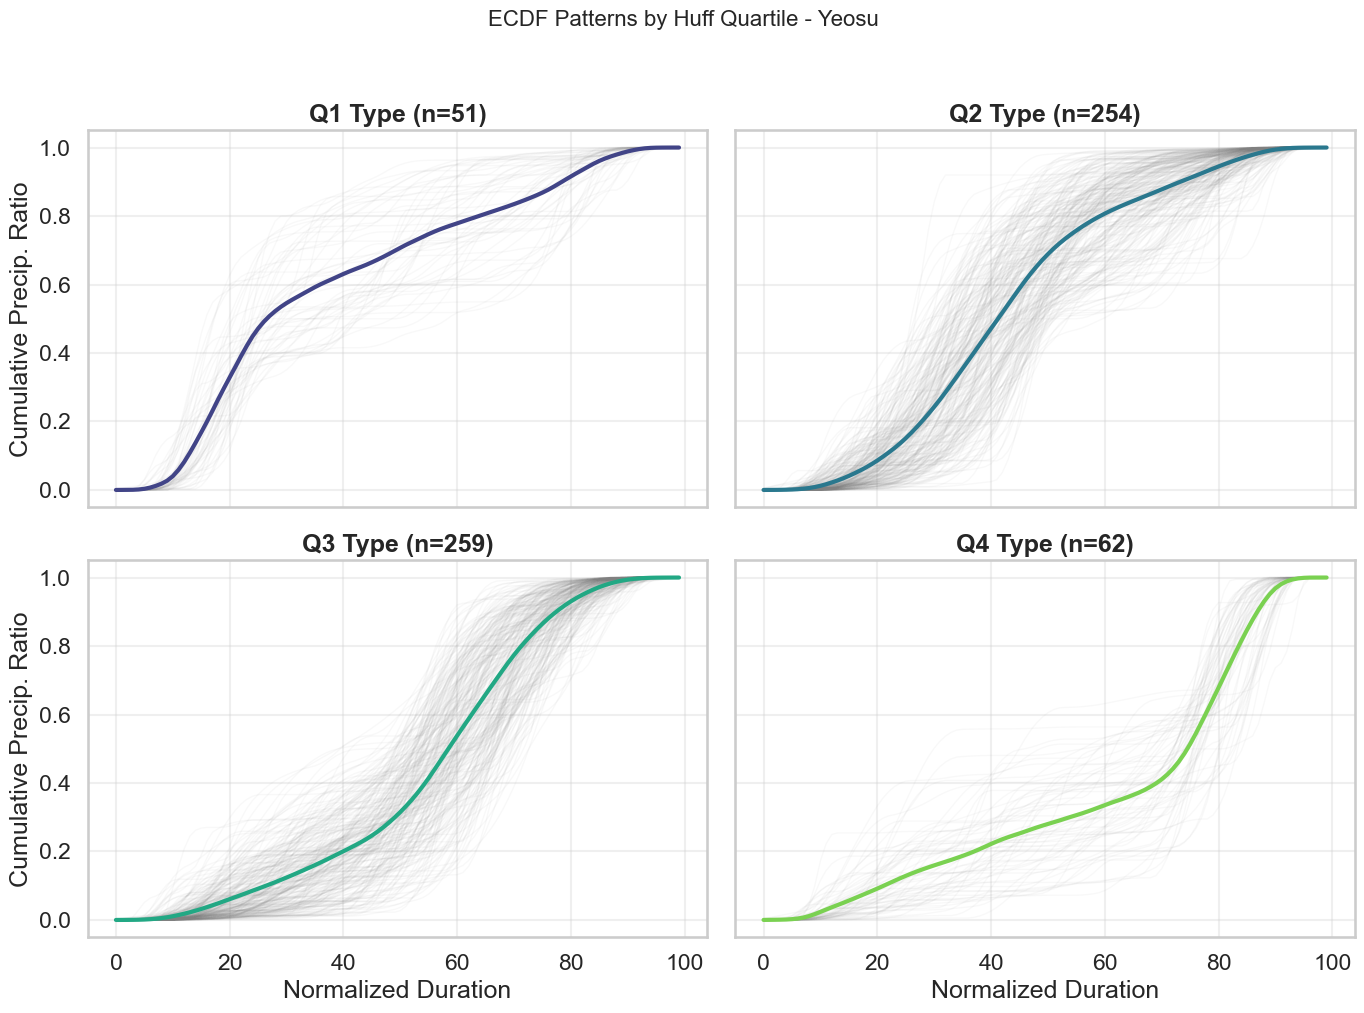

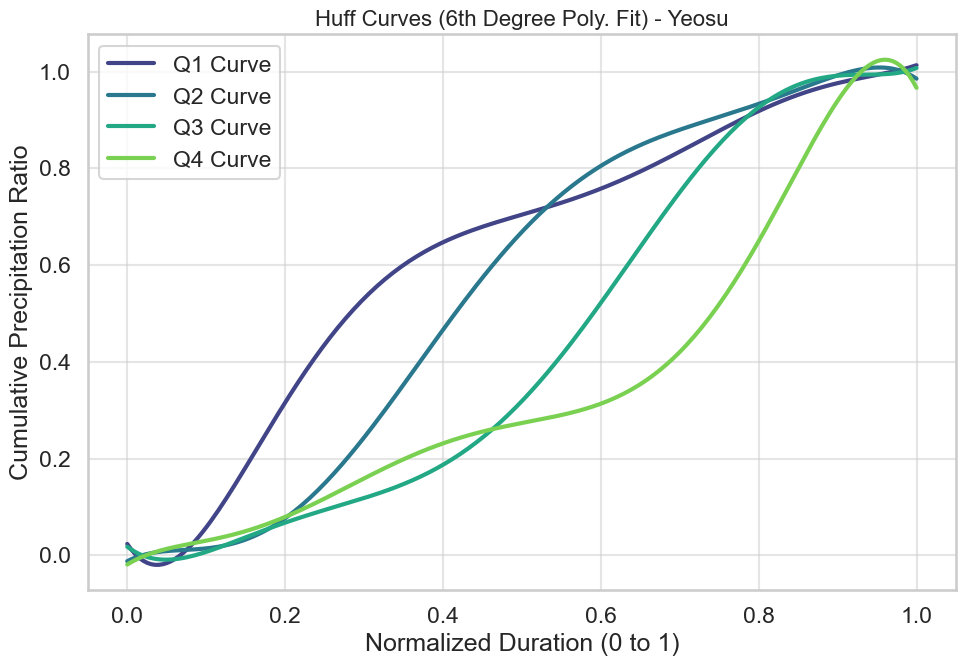

  > Fitting Beta Distribution Parameters (this may take time)...


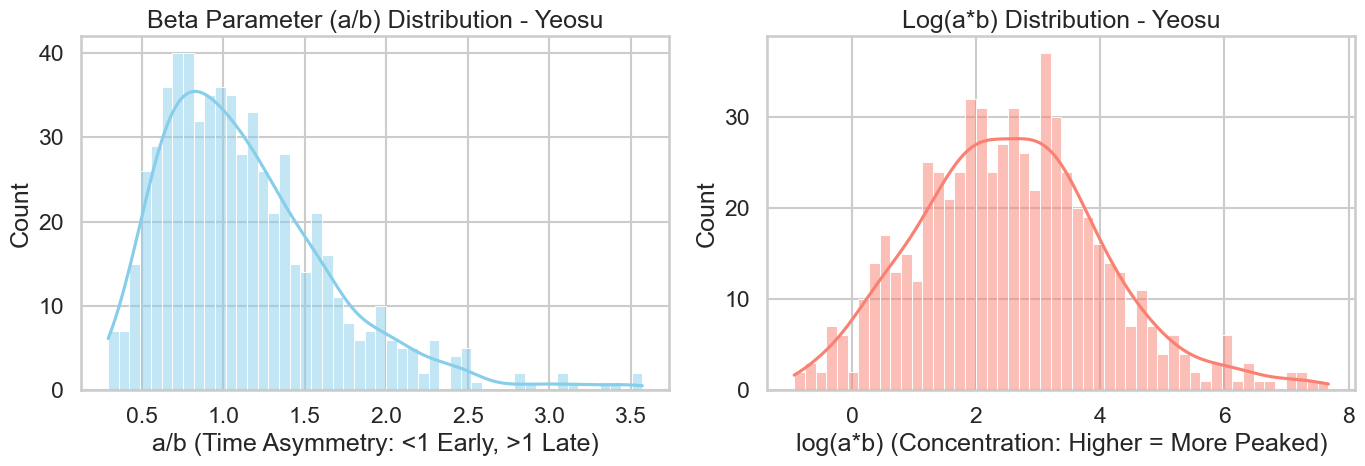

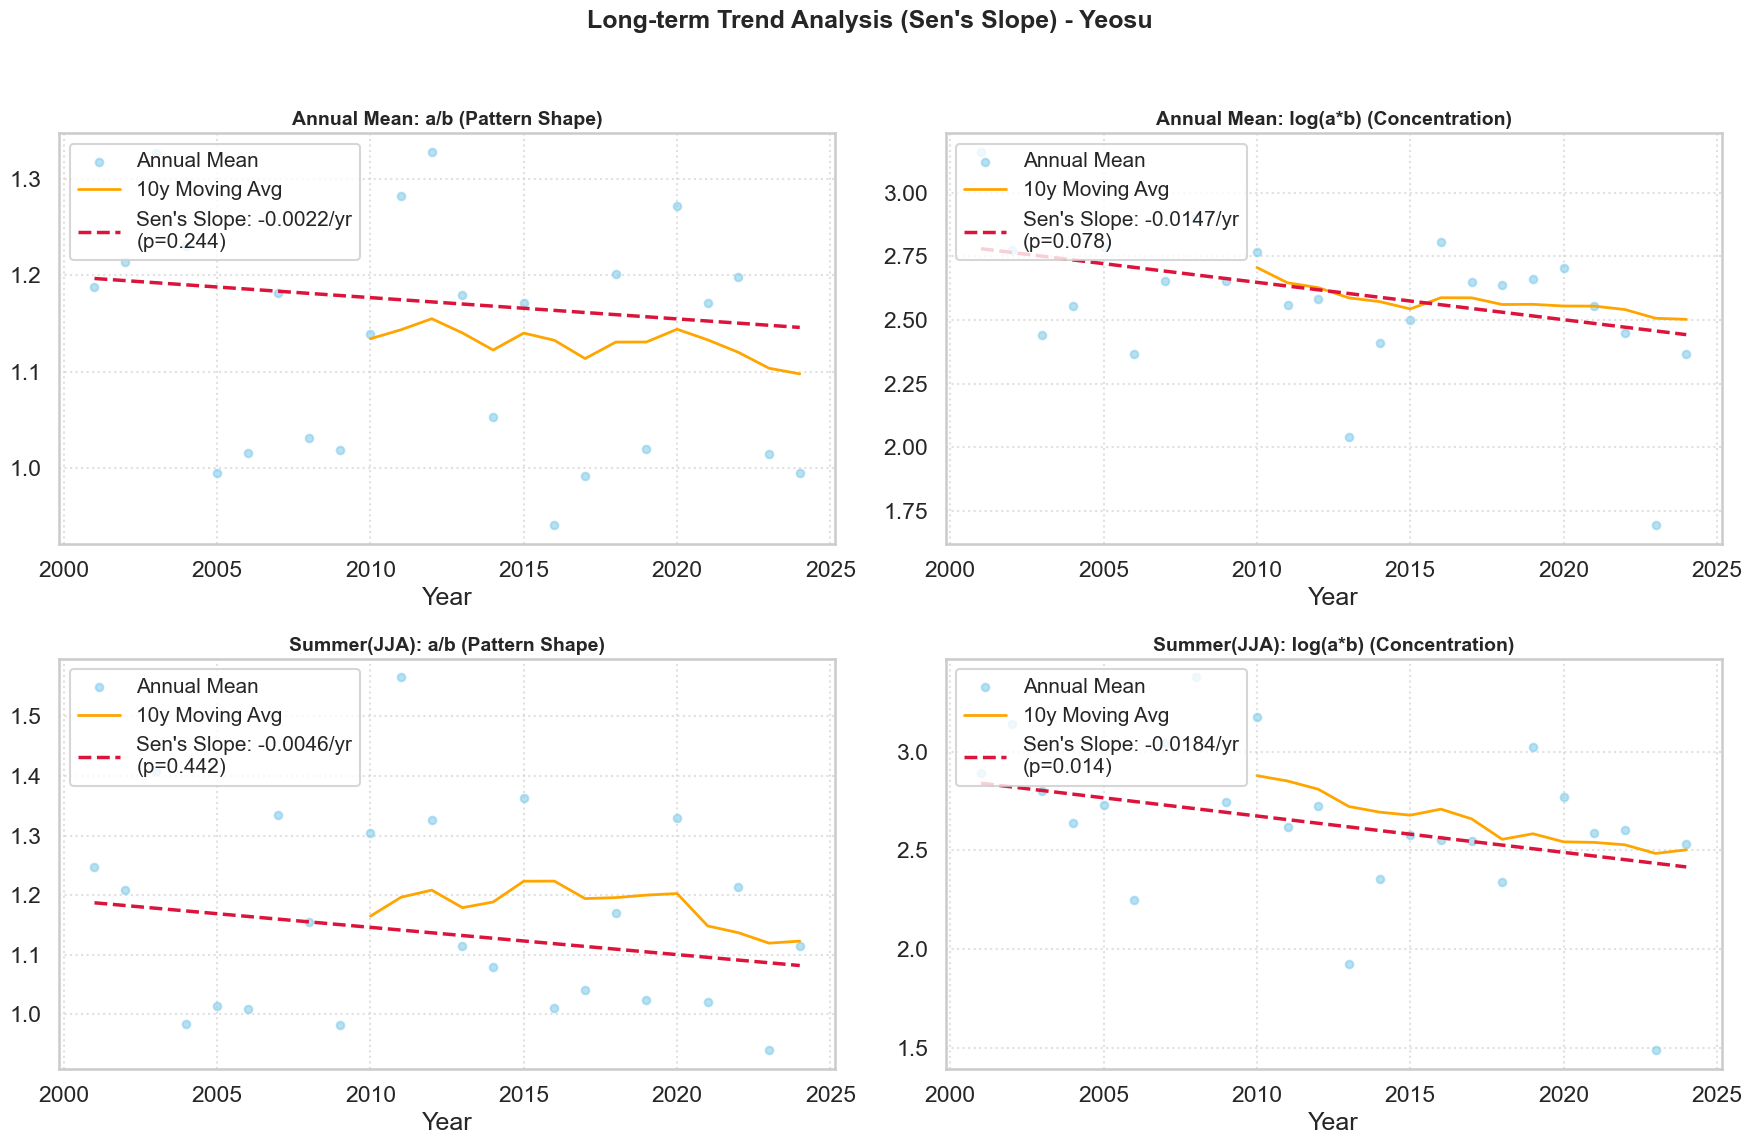

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.isotonic import IsotonicRegression
from scipy.optimize import curve_fit
from scipy import stats
import pymannkendall as mk
import glob
import os
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# --- Plotting Style Configuration ---
# Use seaborn style for better aesthetics
sns.set_theme(style="whitegrid", context="talk")
plt.rcParams['font.family'] = 'sans-serif' # Use standard sans-serif font (Arial, Helvetica, etc.)
plt.rcParams['axes.unicode_minus'] = False

# ==============================================================================
# Helper Functions
# ==============================================================================
def beta_cdf(x, a, b):
    """CDF of Beta distribution for curve fitting."""
    return stats.beta.cdf(x, a, b)

# ==============================================================================
# Class 1: Event Extraction & ECDF Generation
# ==============================================================================
class PrecipitationEventManager:
    def __init__(self, hourly_df, min_duration_hours=10, min_total_precip=2.5, 
                 max_gap_hours=2, precip_threshold=0.1, target_segments=100, zero_precip_ratio_threshold=0.6):
        self.hourly_df = hourly_df.copy()
        self.target_segments = target_segments
        
        # Criteria
        self.min_duration_hours = min_duration_hours
        self.min_total_precip = min_total_precip
        self.max_gap_hours = max_gap_hours
        self.precip_threshold = precip_threshold
        self.zero_precip_ratio_threshold = zero_precip_ratio_threshold
        
        self.precipitation_events = []
        self.ecdf_patterns = np.array([])

    def run(self):
        print("  > Extracting precipitation events...")
        self._extract_precipitation_events()
        self._create_ecdf_patterns()
        return self.precipitation_events, self.ecdf_patterns

    def _extract_precipitation_events(self):
        is_wet_hour = self.hourly_df['precip_mm'] > self.precip_threshold
        smoothing_window = 2 * self.max_gap_hours + 1
        is_part_of_event = is_wet_hour.rolling(window=smoothing_window, center=True, min_periods=1).max().astype(bool)
        event_groups = (is_part_of_event != is_part_of_event.shift()).cumsum()

        for _, event_data in self.hourly_df.groupby(event_groups):
            if not is_part_of_event[event_data.index[0]]:
                continue

            duration = len(event_data)
            total_precip = event_data['precip_mm'].sum()
            
            # Check zero precipitation ratio
            if (event_data['precip_mm'] == 0).sum() / duration > self.zero_precip_ratio_threshold:
                continue

            if duration >= self.min_duration_hours and total_precip >= self.min_total_precip:
                self.precipitation_events.append({
                    'start_time': event_data.index[0],
                    'end_time': event_data.index[-1],
                    'duration_hours': duration,
                    'total_precip_mm': total_precip,
                    'hourly_precip': event_data['precip_mm'].values
                })
        print(f"    - Total Events Extracted: {len(self.precipitation_events)}")

    def _create_ecdf_patterns(self):
        if not self.precipitation_events:
            return

        ecdf_list = []
        for event in self.precipitation_events:
            # Normalize Time
            original_indices = np.linspace(0, 1, len(event['hourly_precip']))
            target_indices = np.linspace(0, 1, self.target_segments)
            normalized_precip = np.interp(target_indices, original_indices, event['hourly_precip'])
            
            # Normalize Cumulative Precipitation
            cumulative = np.cumsum(normalized_precip)
            if cumulative[-1] > 0:
                ecdf_list.append(cumulative / cumulative[-1])
        
        self.ecdf_patterns = np.array(ecdf_list)

# ==============================================================================
# Class 2: Huff Curve Analysis
# ==============================================================================
class HuffCurveAnalyzer:
    def __init__(self, ecdf_patterns):
        self.ecdf_patterns = ecdf_patterns
        self.pattern_labels = []
        self.huff_averages = {}
        self.polynomial_fits = {}
        self.isotonic_fits = {}

    def run(self):
        print("  > Analyzing Huff Curves...")
        if self.ecdf_patterns.size == 0:
            print("    ! Warning: No ECDF patterns to analyze.")
            return None, None
            
        self._label_patterns_by_huff_type()
        self._group_and_average_by_label()
        self._fit_models_to_averages()
        return self.pattern_labels, self.huff_averages

    def _label_patterns_by_huff_type(self):
        time_points = np.linspace(0, 1, self.ecdf_patterns.shape[1])
        for pattern in self.ecdf_patterns:
            q1 = np.interp(0.25, time_points, pattern)
            q2 = np.interp(0.50, time_points, pattern) - q1
            q3 = np.interp(0.75, time_points, pattern) - (q1 + q2)
            q4 = 1.0 - (q1 + q2 + q3)
            
            quartile_precips = [q1, q2, q3, q4]
            max_quartile = np.argmax(quartile_precips) + 1
            self.pattern_labels.append(f"Q{max_quartile}") # Simplified Label: Q1, Q2...

    def _group_and_average_by_label(self):
        df = pd.DataFrame(self.ecdf_patterns)
        df['label'] = self.pattern_labels
        grouped_means = df.groupby('label').mean()
        
        for label, avg_pattern in grouped_means.iterrows():
            self.huff_averages[label] = avg_pattern.values

    def _fit_models_to_averages(self):
        x = np.linspace(0, 1, self.ecdf_patterns.shape[1])
        for label, avg_pattern in self.huff_averages.items():
            # Polynomial Fit
            coeffs = np.polyfit(x, avg_pattern, 6)
            self.polynomial_fits[label] = np.poly1d(coeffs)
            # Isotonic Fit (for reference)
            iso_reg = IsotonicRegression(y_min=0, y_max=1, increasing=True)
            self.isotonic_fits[label] = iso_reg.fit(x, avg_pattern)

# ==============================================================================
# Class 3: Visualization
# ==============================================================================
class AnalysisVisualizer:
    def __init__(self, analyzer_results, city_name="Unknown"):
        self.analyzer = analyzer_results
        self.city_name = city_name

    def plot_all_ecdfs_by_group(self, ecdf_patterns):
        huff_labels = sorted(self.analyzer.huff_averages.keys())
        n_groups = len(huff_labels)
        if n_groups == 0: return

        fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True, sharey=True)
        axes = axes.flatten()
        colors = sns.color_palette("viridis", n_groups)
        
        patterns_df = pd.DataFrame(ecdf_patterns)
        patterns_df['label'] = self.analyzer.pattern_labels

        for i, label in enumerate(huff_labels):
            if i >= len(axes): break
            group_patterns = patterns_df[patterns_df['label'] == label].drop('label', axis=1).values
            
            # Plot individual events (lightly)
            for pattern in group_patterns:
                axes[i].plot(pattern, color='gray', alpha=0.05, linewidth=1)
            
            # Plot Average
            avg_pattern = self.analyzer.huff_averages[label]
            axes[i].plot(avg_pattern, color=colors[i], linewidth=3, label='Mean ECDF')
            
            axes[i].set_title(f'{label} Type (n={len(group_patterns)})', fontweight='bold')
            axes[i].grid(True, alpha=0.3)
            
            if i >= 2: axes[i].set_xlabel('Normalized Duration')
            if i % 2 == 0: axes[i].set_ylabel('Cumulative Precip. Ratio')

        fig.suptitle(f'ECDF Patterns by Huff Quartile - {self.city_name}', fontsize=16, y=1.02)
        plt.tight_layout()
        plt.show()

    def plot_huff_curves_with_regression(self):
        huff_labels = sorted(self.analyzer.huff_averages.keys())
        if not huff_labels: return
            
        plt.figure(figsize=(10, 7))
        x_smooth = np.linspace(0, 1, 200)
        colors = sns.color_palette("viridis", len(huff_labels))

        for i, label in enumerate(huff_labels):
            poly_func = self.analyzer.polynomial_fits[label]
            y_fit = poly_func(x_smooth)
            plt.plot(x_smooth, y_fit, color=colors[i], linewidth=3, label=f'{label} Curve')

        plt.title(f'Huff Curves (6th Degree Poly. Fit) - {self.city_name}', fontsize=16)
        plt.xlabel('Normalized Duration (0 to 1)')
        plt.ylabel('Cumulative Precipitation Ratio')
        plt.legend()
        plt.grid(True, alpha=0.5)
        plt.tight_layout()
        plt.show()

# ==============================================================================
# Trend Analysis Helper
# ==============================================================================
def plot_with_sens_slope(ax, series, title, rolling_window=10):
    """Calculates and plots Sen's Slope trend."""
    if series.empty: return

    # 1. Sen's Slope
    try:
        result = mk.original_test(series.dropna())
        slope = result.slope
        p_value = result.p
        
        # Trend line
        x_vals = series.index
        y_vals = series.values
        trend_line = slope * (x_vals - x_vals[0]) + (np.median(y_vals) - slope * np.median(x_vals - x_vals[0]))
        trend_label = f"Sen's Slope: {slope:.4f}/yr\n(p={p_value:.3f})"
    except:
        slope = 0
        trend_line = np.zeros_like(series)
        trend_label = "Trend calc failed"

    # 2. Plotting
    # Raw data points
    ax.scatter(series.index, series, color='skyblue', alpha=0.6, s=30, label='Annual Mean')
    
    # Rolling Mean
    rolling_mean = series.rolling(window=rolling_window).mean()
    ax.plot(rolling_mean.index, rolling_mean, color='orange', linewidth=2, label=f'{rolling_window}y Moving Avg')
    
    # Trend Line
    ax.plot(series.index, trend_line, color='crimson', linestyle='--', linewidth=2.5, label=trend_label)
            
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel('Year')
    ax.legend(loc='upper left', fontsize='small', frameon=True)
    ax.grid(True, linestyle=':', alpha=0.6)

# ==============================================================================
# Main Execution Pipeline
# ==============================================================================
def process_city_data(df, city_name):
    print(f"\n[{city_name.upper()}] Processing Started...")
    
    # 1. Event Extraction
    event_manager = PrecipitationEventManager(df)
    events, ecdf_patterns = event_manager.run()

    if ecdf_patterns.size == 0:
        print("No events found.")
        return

    # 2. Huff Analysis & Plotting
    huff_analyzer = HuffCurveAnalyzer(ecdf_patterns)
    huff_analyzer.run()
    
    visualizer = AnalysisVisualizer(huff_analyzer, city_name)
    visualizer.plot_all_ecdfs_by_group(ecdf_patterns)
    visualizer.plot_huff_curves_with_regression()

    # 3. Beta Distribution Parameter Fitting
    print("  > Fitting Beta Distribution Parameters (this may take time)...")
    
    # Prepare metadata lists
    years = [e['start_time'].year for e in events]
    months = [e['start_time'].month for e in events]
    
    # Fit Parameters
    x = ecdf_patterns
    params_dict = {}
    
    for i in range(x.shape[0]):
        try:
            # Added try-except to prevent crash on single bad fit
            params, _ = curve_fit(beta_cdf, np.linspace(0, 1, x.shape[1]), x[i], p0=[2, 5], maxfev=2000)
            params_dict[i] = params
        except RuntimeError:
            continue # Skip if fit fails

    # Create Parameter DataFrame
    params_df = pd.DataFrame(params_dict).T
    params_df.columns = ['a', 'b']
    
    # Filter indices that failed fitting
    valid_indices = params_df.index
    params_df["year"] = [years[i] for i in valid_indices]
    params_df["month"] = [months[i] for i in valid_indices]

    # Calculate Indicators
    params_df["a/b"] = params_df["a"] / params_df["b"] # Asymmetry
    params_df["log_ab"] = np.log(params_df["a"] * params_df["b"] + 1e-6) # Peakedness/Concentration

    # 4. Distribution Plots
    plt.figure(figsize=(14, 5))
    
    plt.subplot(1, 2, 1)
    sns.histplot(params_df["a/b"], bins=50, kde=True, color='skyblue')
    plt.title(f'Beta Parameter (a/b) Distribution - {city_name}')
    plt.xlabel('a/b (Time Asymmetry: <1 Early, >1 Late)')

    plt.subplot(1, 2, 2)
    sns.histplot(params_df["log_ab"], bins=50, kde=True, color='salmon')
    plt.title(f'Log(a*b) Distribution - {city_name}')
    plt.xlabel('log(a*b) (Concentration: Higher = More Peaked)')
    
    plt.tight_layout()
    plt.show()

    # 5. Trend Analysis (Sen's Slope)
    # Aggregate Data
    params_df_yearly = params_df.groupby('year').mean()
    
    is_summer = params_df['month'].isin([6, 7, 8])
    params_df_summer = params_df[is_summer].groupby('year').mean()

    # Create Trend Plots
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    fig.suptitle(f"Long-term Trend Analysis (Sen's Slope) - {city_name}", fontsize=18, fontweight='bold', y=0.98)

    # All Seasons
    plot_with_sens_slope(axes[0, 0], params_df_yearly['a/b'], 'Annual Mean: a/b (Pattern Shape)')
    plot_with_sens_slope(axes[0, 1], params_df_yearly['log_ab'], 'Annual Mean: log(a*b) (Concentration)')

    # Summer Only
    plot_with_sens_slope(axes[1, 0], params_df_summer['a/b'], 'Summer(JJA): a/b (Pattern Shape)')
    plot_with_sens_slope(axes[1, 1], params_df_summer['log_ab'], 'Summer(JJA): log(a*b) (Concentration)')

    plt.tight_layout(rect=[0, 0.02, 1, 0.96])
    plt.show()

# ==============================================================================
# Run
# ==============================================================================
if __name__ == "__main__":
    # Check path
    df_paths = glob.glob("./data/*_hourly.csv")
    
    if not df_paths:
        print("No data files found in ./data/")
    
    for path in df_paths:
        # Extract City Name from filename (e.g., "./data/seoul_hourly.csv" -> "Seoul")
        filename = os.path.basename(path)
        city_name = filename.split('_')[0].capitalize() 
        
        # Load Data
        df = pd.read_csv(path)
        df["datetime"] = pd.to_datetime(df["datetime"])
        df.set_index("datetime", inplace=True)
        df = df[["precip_mm"]]
        df.fillna(0, inplace=True)
        df = df[~df.index.duplicated(keep='first')]
        
        # Execute
        process_city_data(df, city_name)